In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

Cloning into 'deep-learning-polytech-tp6-7'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 19 (delta 2), reused 7 (delta 1), pack-reused 8
Unpacking objects: 100% (19/19), done.


In [ ]:
cd deep-learning-polytech-tp6-7

/content/deep-learning-polytech-tp6-7


In [ ]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class AccLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        self.fig = plt.figure()

    def update(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        plt.figure(self.fig.number)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.array(self.acc_train), label="acc. train")
        plt.plot(np.array(self.acc_test), label="acc. test")
        plt.title("Accuracy / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(self.loss_train), label="loss train")
        plt.plot(np.array(self.loss_test), label="loss test")
        plt.title("Loss / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.suptitle("With batch normalization")
        plt.legend()
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)

In [ ]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On définit d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Conv2d(64, 64, 5, stride=1, padding=2),
            nn.BatchNorm2d(64),            
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0, ceil_mode=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 1000),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1000, 10)
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    
    train_dataset = datasets.CIFAR10(
        PATH, train=True, download=True, transform=transforms.Compose(
            [transforms.RandomHorizontalFlip(),
             transforms.RandomCrop(size=28),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.491, 0.482, 0.447],
                                  std=[0.202, 0.199, 0.201])]))

    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(size=28),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           mean=[0.491, 0.482, 0.447],
                                           std=[0.202, 0.199, 0.201])
                                   ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        lr_sched.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 2.3513 (2.3513)	Prec@1   8.6 (  8.6)	Prec@5  49.2 ( 49.2)


<Figure size 432x288 with 0 Axes>

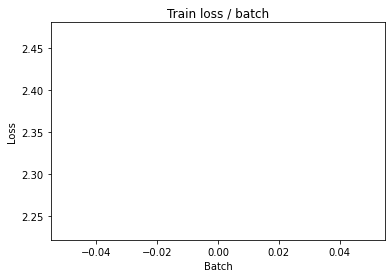

[TRAIN Batch 200/391]	Time 0.046s (0.038s)	Loss 1.5866 (1.6492)	Prec@1  43.8 ( 39.0)	Prec@5  89.8 ( 88.7)


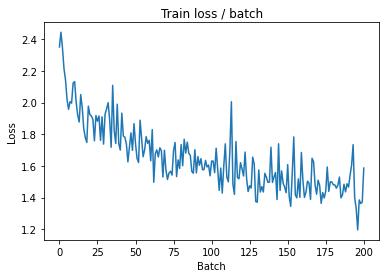


===============> Total time 14s	Avg loss 1.4828	Avg Prec@1 45.72 %	Avg Prec@5 91.32 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 1.7047 (1.7047)	Prec@1  45.3 ( 45.3)	Prec@5  90.6 ( 90.6)

===============> Total time 2s	Avg loss 1.6647	Avg Prec@1 47.62 %	Avg Prec@5 90.56 %



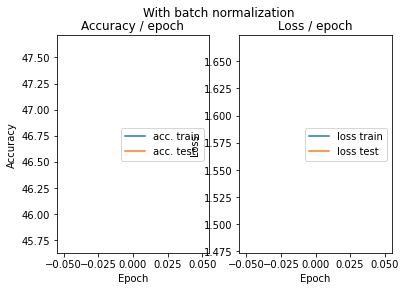

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 1.1452 (1.1452)	Prec@1  57.8 ( 57.8)	Prec@5  98.4 ( 98.4)


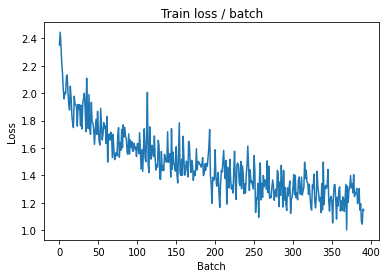

[TRAIN Batch 200/391]	Time 0.016s (0.038s)	Loss 1.1788 (1.0931)	Prec@1  62.5 ( 61.0)	Prec@5  96.1 ( 96.2)


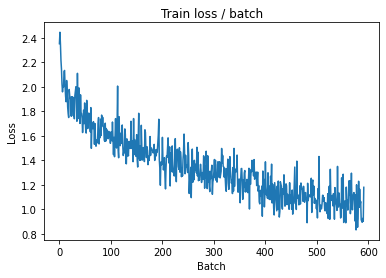


===============> Total time 14s	Avg loss 1.0570	Avg Prec@1 62.68 %	Avg Prec@5 96.34 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.9449 (0.9449)	Prec@1  73.4 ( 73.4)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 1.0114	Avg Prec@1 65.28 %	Avg Prec@5 96.04 %



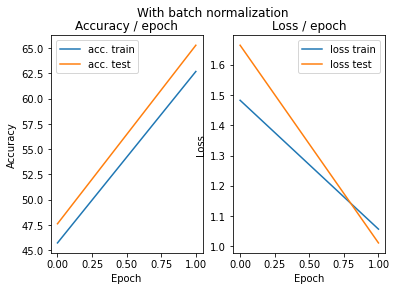

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.9999 (0.9999)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)


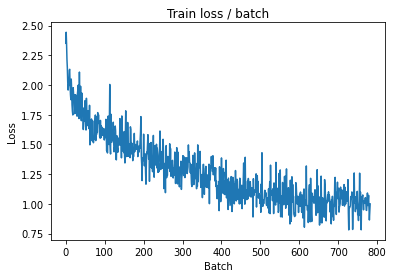

[TRAIN Batch 200/391]	Time 0.049s (0.038s)	Loss 0.9162 (0.8819)	Prec@1  64.1 ( 69.1)	Prec@5  97.7 ( 97.3)


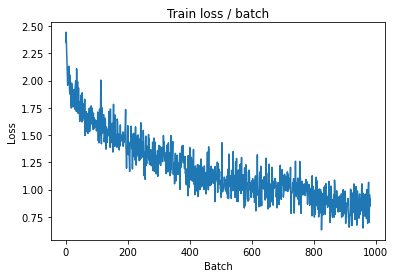


===============> Total time 14s	Avg loss 0.8715	Avg Prec@1 69.46 %	Avg Prec@5 97.46 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.7464 (0.7464)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8171	Avg Prec@1 72.14 %	Avg Prec@5 97.83 %



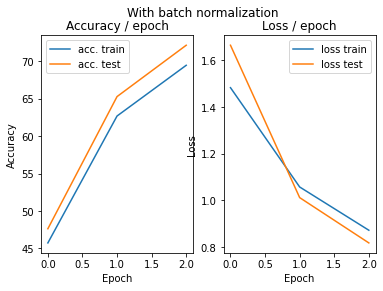

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 0.8258 (0.8258)	Prec@1  71.1 ( 71.1)	Prec@5  98.4 ( 98.4)


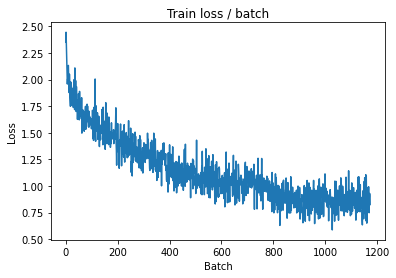

[TRAIN Batch 200/391]	Time 0.067s (0.037s)	Loss 0.7695 (0.7843)	Prec@1  75.0 ( 72.2)	Prec@5  96.9 ( 98.0)


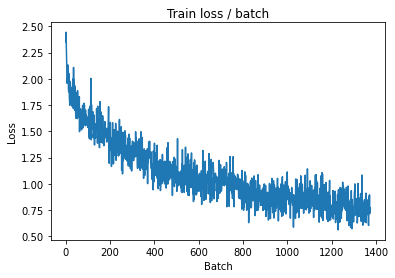


===============> Total time 14s	Avg loss 0.7763	Avg Prec@1 72.75 %	Avg Prec@5 98.00 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.8131 (0.8131)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8238	Avg Prec@1 71.71 %	Avg Prec@5 97.91 %



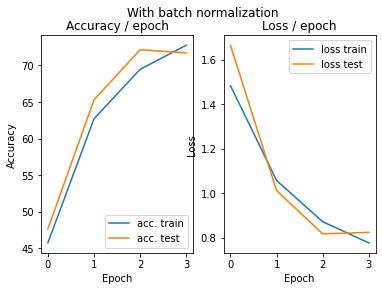

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.8160 (0.8160)	Prec@1  69.5 ( 69.5)	Prec@5  98.4 ( 98.4)


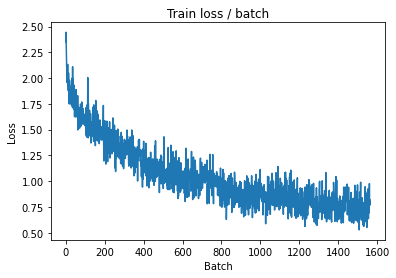

[TRAIN Batch 200/391]	Time 0.062s (0.039s)	Loss 0.6466 (0.7022)	Prec@1  74.2 ( 75.6)	Prec@5  99.2 ( 98.4)


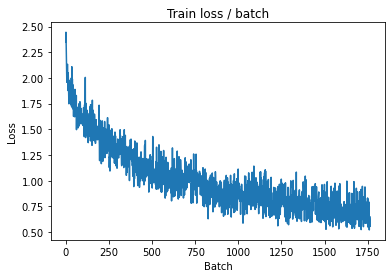


===============> Total time 15s	Avg loss 0.6985	Avg Prec@1 75.77 %	Avg Prec@5 98.34 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.6900 (0.6900)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6999	Avg Prec@1 76.25 %	Avg Prec@5 98.19 %



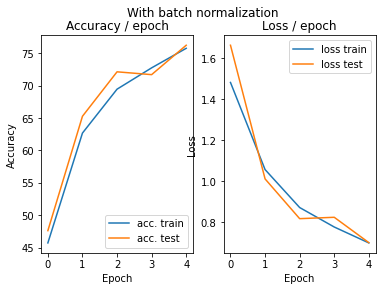

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.6233 (0.6233)	Prec@1  78.1 ( 78.1)	Prec@5  99.2 ( 99.2)


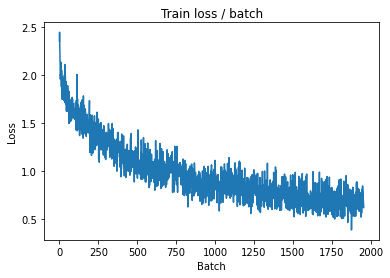

[TRAIN Batch 200/391]	Time 0.034s (0.038s)	Loss 0.7623 (0.6512)	Prec@1  75.0 ( 77.6)	Prec@5  97.7 ( 98.6)


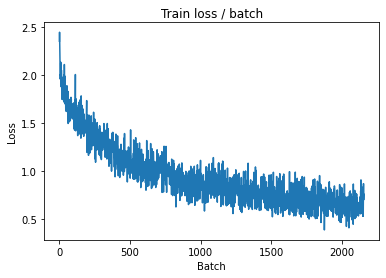


===============> Total time 14s	Avg loss 0.6453	Avg Prec@1 77.60 %	Avg Prec@5 98.67 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.6075 (0.6075)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6496	Avg Prec@1 77.76 %	Avg Prec@5 98.77 %



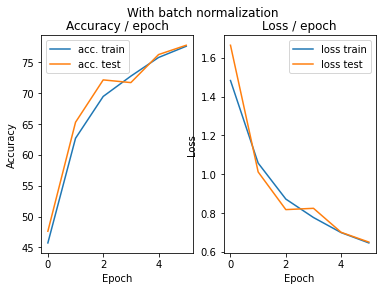

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.162s (0.162s)	Loss 0.5916 (0.5916)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


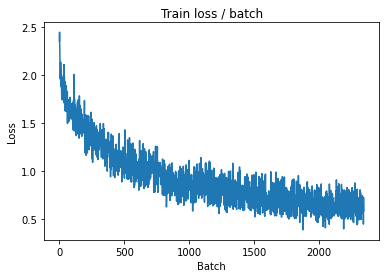

[TRAIN Batch 200/391]	Time 0.027s (0.038s)	Loss 0.6070 (0.5949)	Prec@1  76.6 ( 79.1)	Prec@5  99.2 ( 98.9)


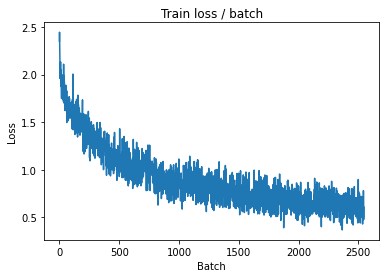


===============> Total time 14s	Avg loss 0.5981	Avg Prec@1 79.04 %	Avg Prec@5 98.81 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.7071 (0.7071)	Prec@1  77.3 ( 77.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6488	Avg Prec@1 77.74 %	Avg Prec@5 98.50 %



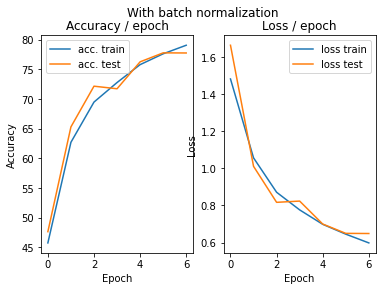

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.6977 (0.6977)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)


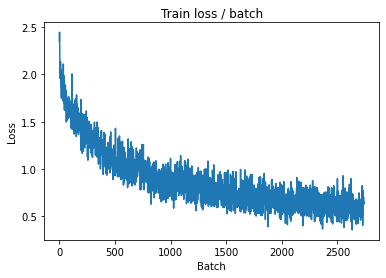

[TRAIN Batch 200/391]	Time 0.056s (0.041s)	Loss 0.6162 (0.5564)	Prec@1  75.0 ( 80.5)	Prec@5  99.2 ( 99.0)


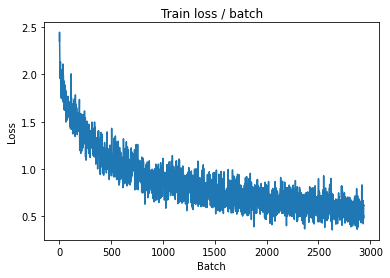


===============> Total time 15s	Avg loss 0.5557	Avg Prec@1 80.51 %	Avg Prec@5 99.01 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.6087 (0.6087)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6248	Avg Prec@1 79.28 %	Avg Prec@5 98.83 %



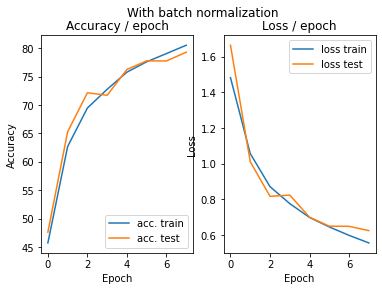

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.4730 (0.4730)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


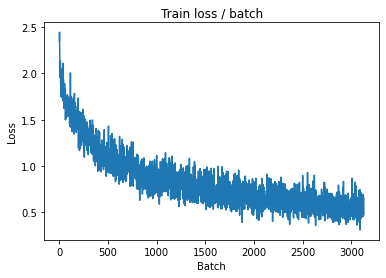

[TRAIN Batch 200/391]	Time 0.018s (0.042s)	Loss 0.4965 (0.5175)	Prec@1  85.2 ( 82.0)	Prec@5  98.4 ( 99.1)


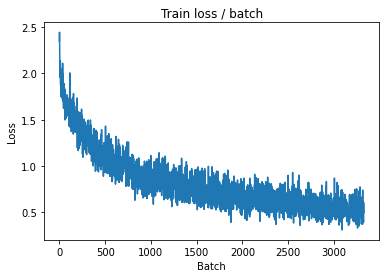


===============> Total time 15s	Avg loss 0.5255	Avg Prec@1 81.79 %	Avg Prec@5 99.09 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.6037 (0.6037)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.5951	Avg Prec@1 79.91 %	Avg Prec@5 98.83 %



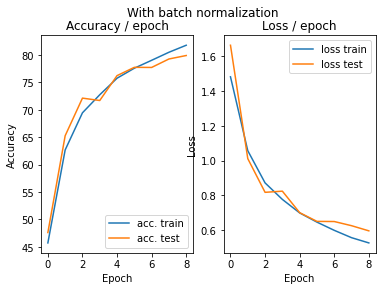

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.4934 (0.4934)	Prec@1  82.0 ( 82.0)	Prec@5  99.2 ( 99.2)


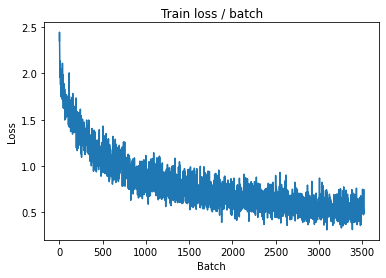

[TRAIN Batch 200/391]	Time 0.023s (0.040s)	Loss 0.5936 (0.4898)	Prec@1  81.2 ( 82.8)	Prec@5  99.2 ( 99.3)


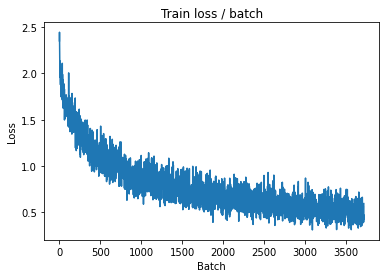


===============> Total time 14s	Avg loss 0.4914	Avg Prec@1 82.86 %	Avg Prec@5 99.21 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.5203 (0.5203)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5755	Avg Prec@1 80.82 %	Avg Prec@5 98.90 %



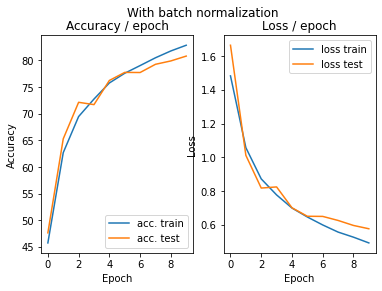

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.4326 (0.4326)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


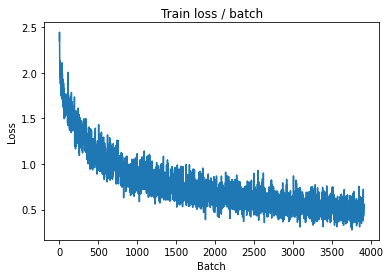

[TRAIN Batch 200/391]	Time 0.017s (0.037s)	Loss 0.4849 (0.4658)	Prec@1  83.6 ( 83.8)	Prec@5  99.2 ( 99.4)


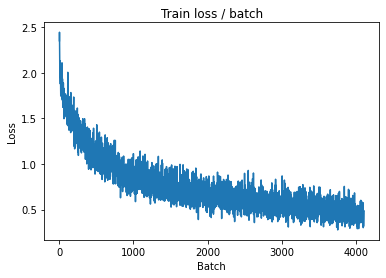


===============> Total time 14s	Avg loss 0.4662	Avg Prec@1 83.69 %	Avg Prec@5 99.35 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.5131 (0.5131)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5859	Avg Prec@1 80.70 %	Avg Prec@5 98.87 %



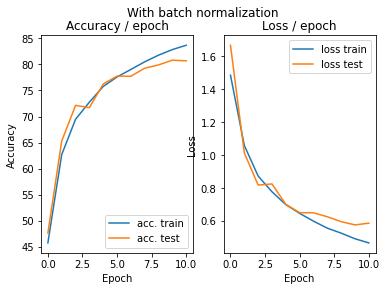

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.165s (0.165s)	Loss 0.4045 (0.4045)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


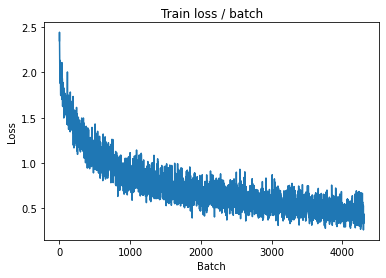

[TRAIN Batch 200/391]	Time 0.017s (0.038s)	Loss 0.3740 (0.4356)	Prec@1  87.5 ( 84.8)	Prec@5 100.0 ( 99.4)


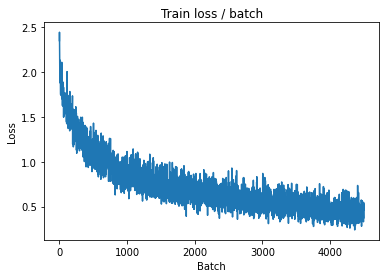


===============> Total time 14s	Avg loss 0.4382	Avg Prec@1 84.57 %	Avg Prec@5 99.43 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 0.4667 (0.4667)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5589	Avg Prec@1 81.20 %	Avg Prec@5 99.00 %



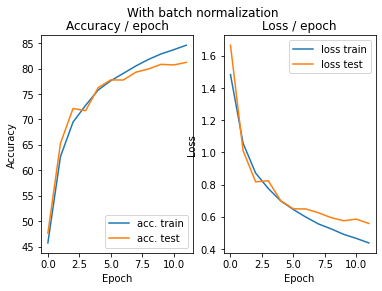

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.3162 (0.3162)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)


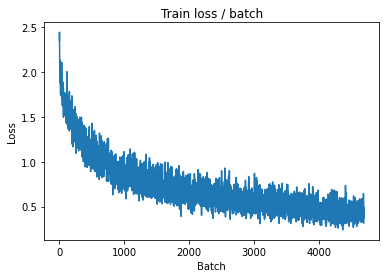

[TRAIN Batch 200/391]	Time 0.015s (0.037s)	Loss 0.4003 (0.4085)	Prec@1  86.7 ( 85.8)	Prec@5  97.7 ( 99.5)


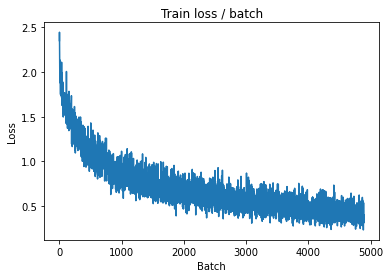


===============> Total time 14s	Avg loss 0.4140	Avg Prec@1 85.54 %	Avg Prec@5 99.44 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.5710 (0.5710)	Prec@1  84.4 ( 84.4)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.5529	Avg Prec@1 82.03 %	Avg Prec@5 98.95 %



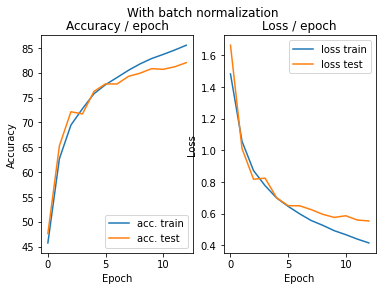

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.4649 (0.4649)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


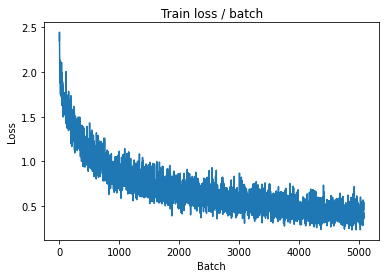

[TRAIN Batch 200/391]	Time 0.041s (0.037s)	Loss 0.4384 (0.3981)	Prec@1  82.0 ( 86.2)	Prec@5  99.2 ( 99.5)


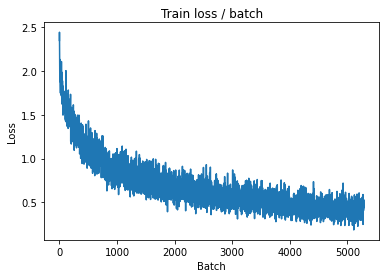


===============> Total time 14s	Avg loss 0.3952	Avg Prec@1 86.15 %	Avg Prec@5 99.52 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.5941 (0.5941)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5686	Avg Prec@1 81.53 %	Avg Prec@5 99.07 %



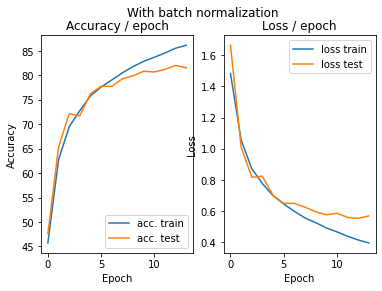

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.3642 (0.3642)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


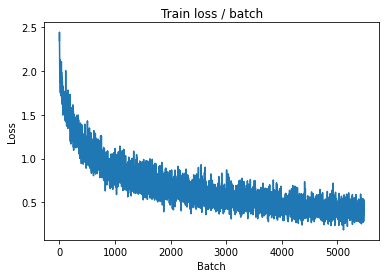

[TRAIN Batch 200/391]	Time 0.060s (0.039s)	Loss 0.4072 (0.3689)	Prec@1  84.4 ( 87.0)	Prec@5 100.0 ( 99.6)


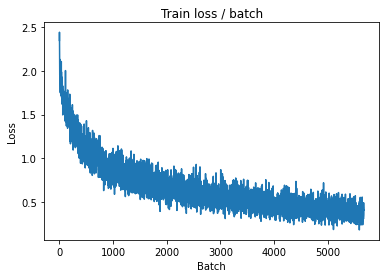


===============> Total time 15s	Avg loss 0.3688	Avg Prec@1 87.06 %	Avg Prec@5 99.57 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.5472 (0.5472)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5754	Avg Prec@1 81.34 %	Avg Prec@5 99.07 %



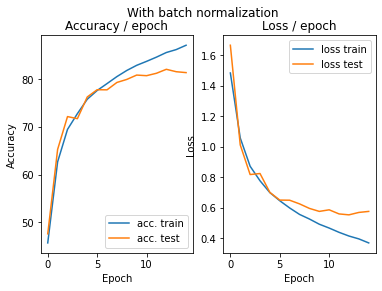

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.3207 (0.3207)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


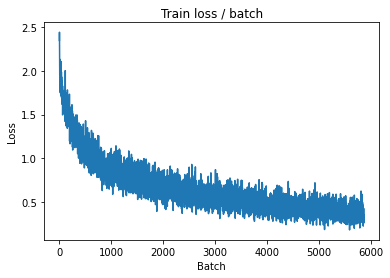

[TRAIN Batch 200/391]	Time 0.015s (0.038s)	Loss 0.2678 (0.3497)	Prec@1  89.1 ( 87.7)	Prec@5 100.0 ( 99.7)


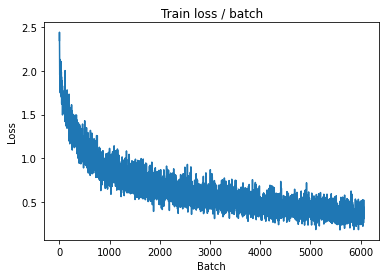


===============> Total time 14s	Avg loss 0.3511	Avg Prec@1 87.60 %	Avg Prec@5 99.64 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.5138 (0.5138)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5409	Avg Prec@1 83.02 %	Avg Prec@5 98.99 %



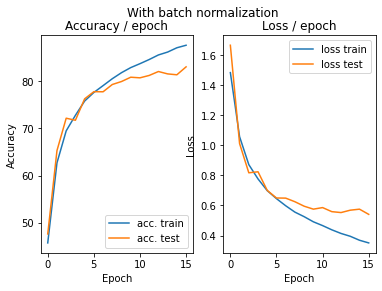

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.164s (0.164s)	Loss 0.3465 (0.3465)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)


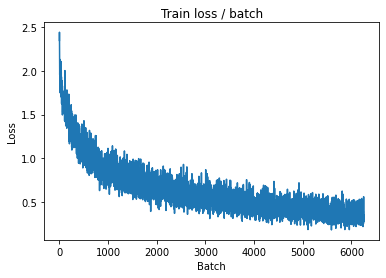

[TRAIN Batch 200/391]	Time 0.015s (0.041s)	Loss 0.3112 (0.3215)	Prec@1  88.3 ( 88.5)	Prec@5  99.2 ( 99.7)


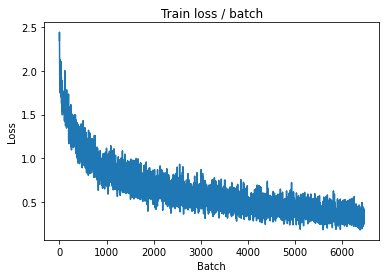


===============> Total time 15s	Avg loss 0.3301	Avg Prec@1 88.41 %	Avg Prec@5 99.69 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.5006 (0.5006)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5257	Avg Prec@1 82.95 %	Avg Prec@5 99.08 %



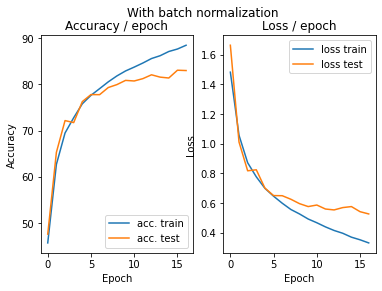

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.4055 (0.4055)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)


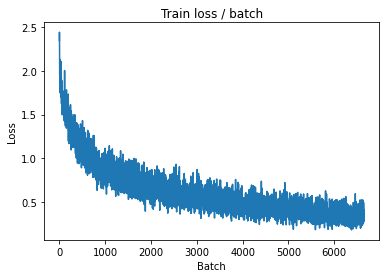

[TRAIN Batch 200/391]	Time 0.010s (0.038s)	Loss 0.3322 (0.3085)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.7)


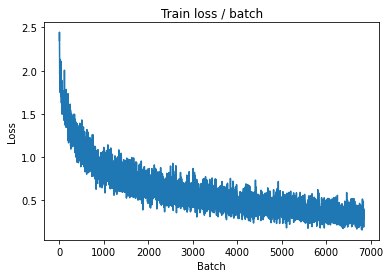


===============> Total time 14s	Avg loss 0.3122	Avg Prec@1 89.01 %	Avg Prec@5 99.71 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 0.5043 (0.5043)	Prec@1  86.7 ( 86.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.5380	Avg Prec@1 82.60 %	Avg Prec@5 99.04 %



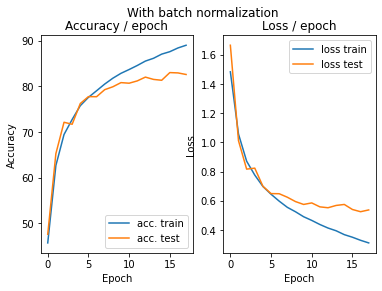

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.3389 (0.3389)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


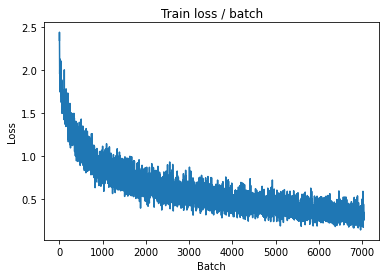

[TRAIN Batch 200/391]	Time 0.031s (0.038s)	Loss 0.3346 (0.2924)	Prec@1  87.5 ( 89.9)	Prec@5 100.0 ( 99.8)


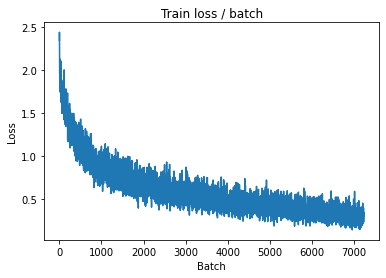


===============> Total time 14s	Avg loss 0.2974	Avg Prec@1 89.61 %	Avg Prec@5 99.78 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.4906 (0.4906)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5205	Avg Prec@1 83.38 %	Avg Prec@5 99.06 %



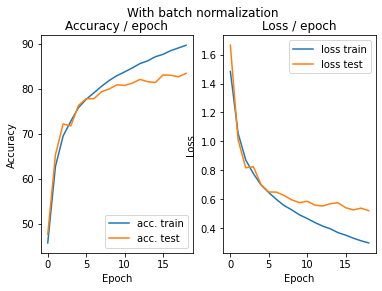

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.2609 (0.2609)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)


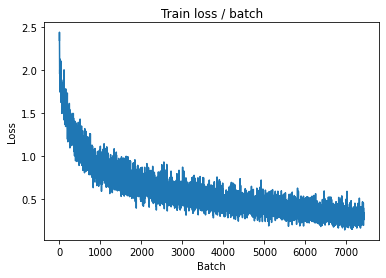

[TRAIN Batch 200/391]	Time 0.075s (0.039s)	Loss 0.2981 (0.2841)	Prec@1  87.5 ( 90.0)	Prec@5 100.0 ( 99.8)


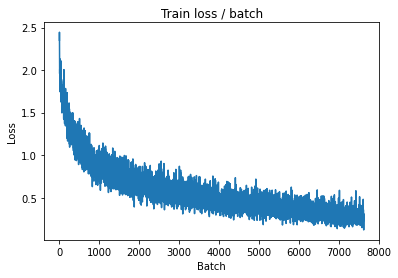


===============> Total time 15s	Avg loss 0.2839	Avg Prec@1 89.98 %	Avg Prec@5 99.78 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.5188 (0.5188)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5255	Avg Prec@1 83.70 %	Avg Prec@5 99.19 %



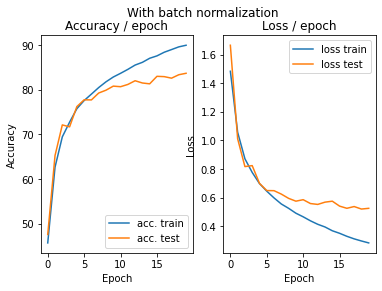

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 0.3952 (0.3952)	Prec@1  85.2 ( 85.2)	Prec@5 100.0 (100.0)


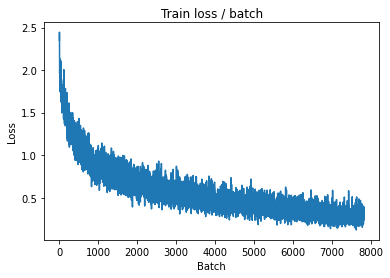

[TRAIN Batch 200/391]	Time 0.011s (0.038s)	Loss 0.2120 (0.2626)	Prec@1  91.4 ( 90.7)	Prec@5 100.0 ( 99.8)


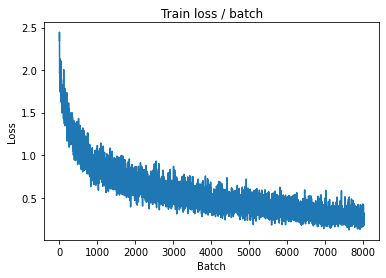


===============> Total time 15s	Avg loss 0.2676	Avg Prec@1 90.54 %	Avg Prec@5 99.80 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.4826 (0.4826)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5329	Avg Prec@1 84.01 %	Avg Prec@5 99.17 %



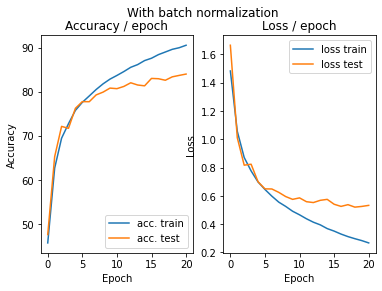

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.2348 (0.2348)	Prec@1  89.8 ( 89.8)	Prec@5 100.0 (100.0)


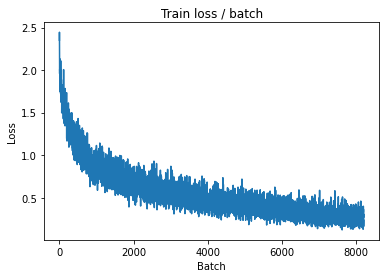

[TRAIN Batch 200/391]	Time 0.018s (0.039s)	Loss 0.2946 (0.2515)	Prec@1  92.2 ( 91.2)	Prec@5  99.2 ( 99.9)


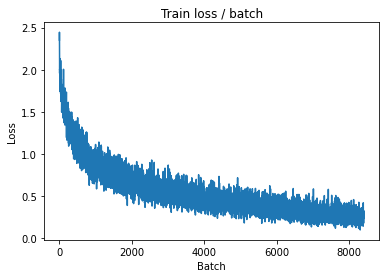


===============> Total time 15s	Avg loss 0.2532	Avg Prec@1 91.04 %	Avg Prec@5 99.84 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 0.5127 (0.5127)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5602	Avg Prec@1 83.32 %	Avg Prec@5 99.02 %



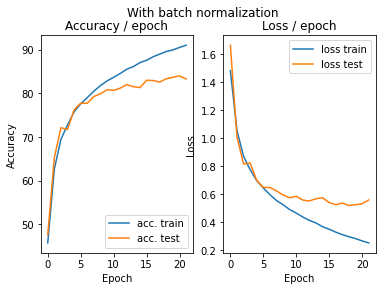

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.2348 (0.2348)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


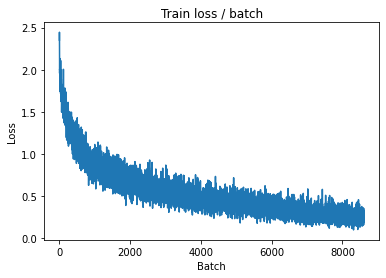

[TRAIN Batch 200/391]	Time 0.058s (0.039s)	Loss 0.3346 (0.2365)	Prec@1  86.7 ( 91.7)	Prec@5 100.0 ( 99.9)


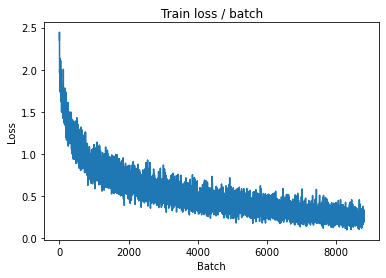


===============> Total time 15s	Avg loss 0.2390	Avg Prec@1 91.68 %	Avg Prec@5 99.87 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.4190 (0.4190)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5251	Avg Prec@1 83.98 %	Avg Prec@5 99.12 %



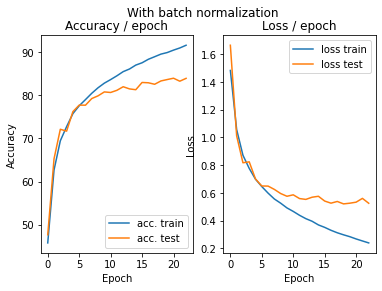

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.3390 (0.3390)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)


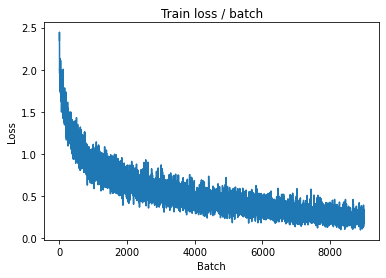

[TRAIN Batch 200/391]	Time 0.024s (0.040s)	Loss 0.1714 (0.2269)	Prec@1  94.5 ( 92.0)	Prec@5 100.0 ( 99.9)


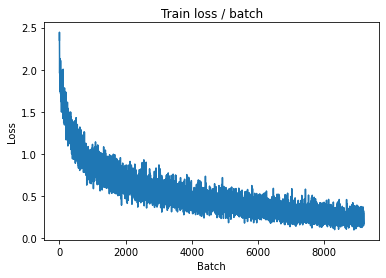


===============> Total time 15s	Avg loss 0.2263	Avg Prec@1 92.04 %	Avg Prec@5 99.89 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.5470 (0.5470)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5569	Avg Prec@1 83.72 %	Avg Prec@5 99.09 %



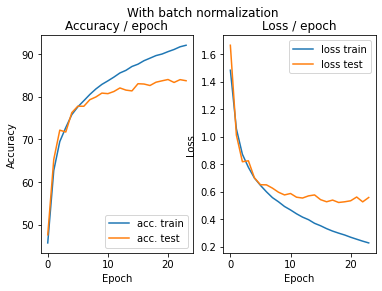

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.1951 (0.1951)	Prec@1  93.8 ( 93.8)	Prec@5  99.2 ( 99.2)


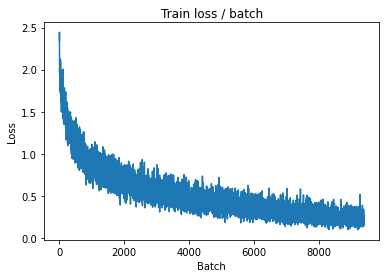

[TRAIN Batch 200/391]	Time 0.060s (0.040s)	Loss 0.1902 (0.2096)	Prec@1  93.8 ( 92.8)	Prec@5 100.0 ( 99.9)


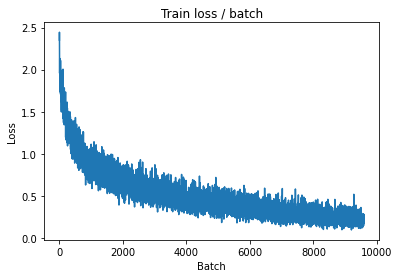


===============> Total time 15s	Avg loss 0.2127	Avg Prec@1 92.54 %	Avg Prec@5 99.88 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.4897 (0.4897)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5321	Avg Prec@1 84.34 %	Avg Prec@5 99.15 %



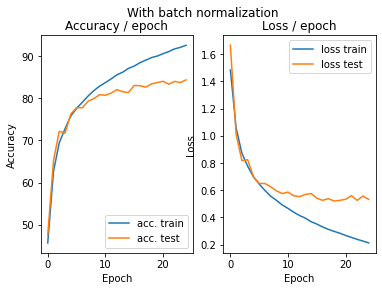

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.2750 (0.2750)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)


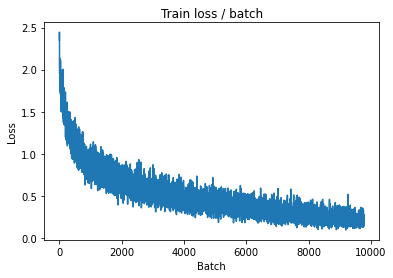

[TRAIN Batch 200/391]	Time 0.035s (0.039s)	Loss 0.2194 (0.2045)	Prec@1  92.2 ( 92.9)	Prec@5 100.0 ( 99.9)


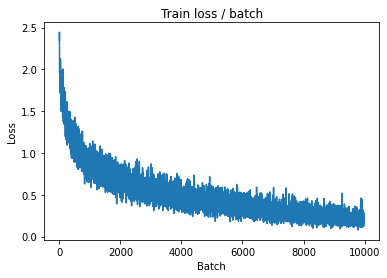


===============> Total time 14s	Avg loss 0.2051	Avg Prec@1 92.88 %	Avg Prec@5 99.89 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 0.4992 (0.4992)	Prec@1  85.2 ( 85.2)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5394	Avg Prec@1 84.24 %	Avg Prec@5 99.17 %



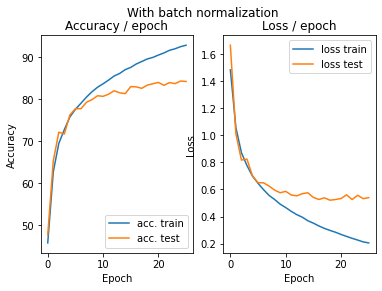

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.1399 (0.1399)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


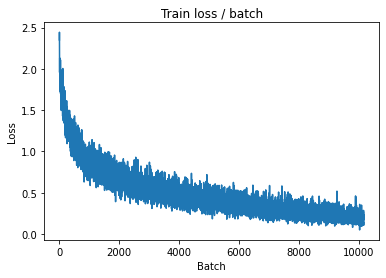

[TRAIN Batch 200/391]	Time 0.054s (0.040s)	Loss 0.3131 (0.1852)	Prec@1  90.6 ( 93.8)	Prec@5  99.2 ( 99.9)


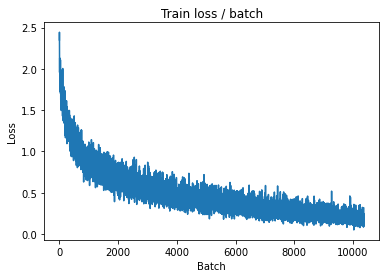


===============> Total time 15s	Avg loss 0.1951	Avg Prec@1 93.24 %	Avg Prec@5 99.91 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.4393 (0.4393)	Prec@1  86.7 ( 86.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5367	Avg Prec@1 84.41 %	Avg Prec@5 99.20 %



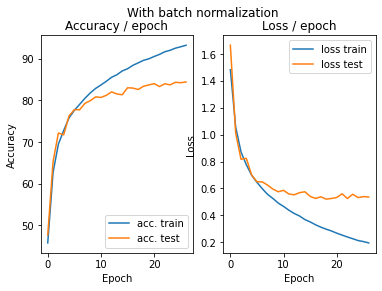

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.1204 (0.1204)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


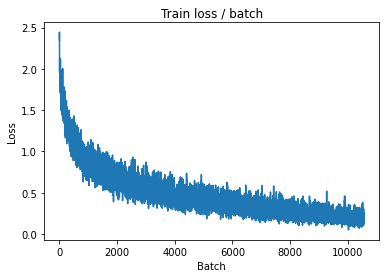

[TRAIN Batch 200/391]	Time 0.053s (0.040s)	Loss 0.1678 (0.1814)	Prec@1  94.5 ( 93.8)	Prec@5 100.0 ( 99.9)


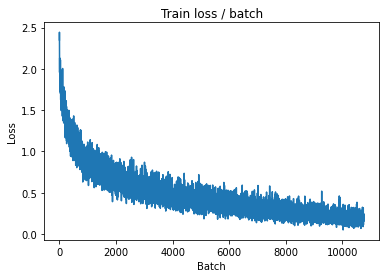


===============> Total time 15s	Avg loss 0.1884	Avg Prec@1 93.49 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.4801 (0.4801)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5463	Avg Prec@1 84.42 %	Avg Prec@5 99.08 %



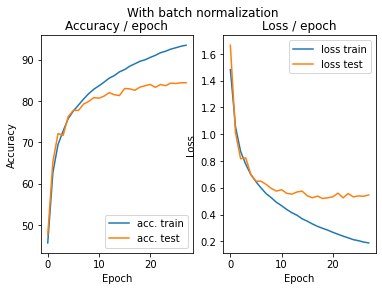

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.2364 (0.2364)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


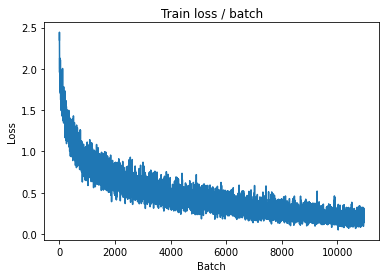

[TRAIN Batch 200/391]	Time 0.063s (0.039s)	Loss 0.1363 (0.1744)	Prec@1  96.1 ( 93.8)	Prec@5 100.0 ( 99.9)


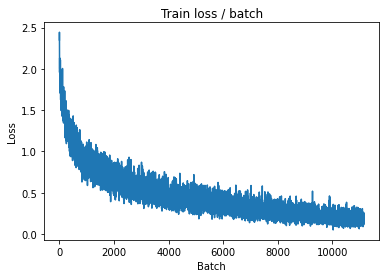


===============> Total time 15s	Avg loss 0.1791	Avg Prec@1 93.61 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.4989 (0.4989)	Prec@1  88.3 ( 88.3)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.5414	Avg Prec@1 84.69 %	Avg Prec@5 99.14 %



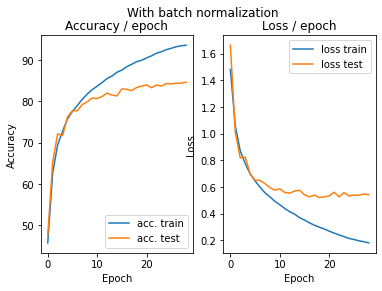

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.1743 (0.1743)	Prec@1  93.0 ( 93.0)	Prec@5 100.0 (100.0)


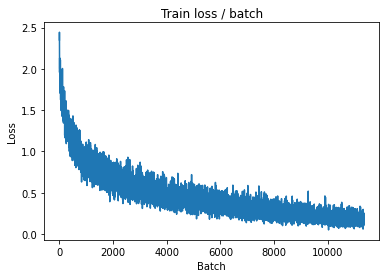

[TRAIN Batch 200/391]	Time 0.061s (0.040s)	Loss 0.2490 (0.1658)	Prec@1  89.8 ( 94.1)	Prec@5 100.0 ( 99.9)


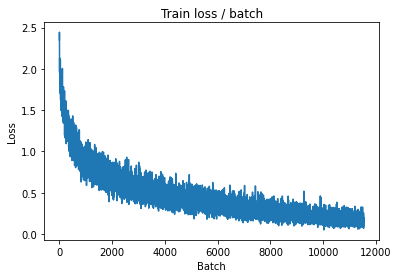


===============> Total time 15s	Avg loss 0.1680	Avg Prec@1 94.02 %	Avg Prec@5 99.94 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 0.5007 (0.5007)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5671	Avg Prec@1 84.41 %	Avg Prec@5 99.20 %



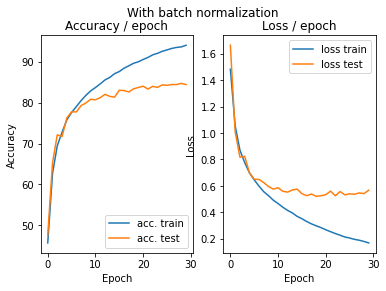

=== EPOCH 31 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.0567 (0.0567)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


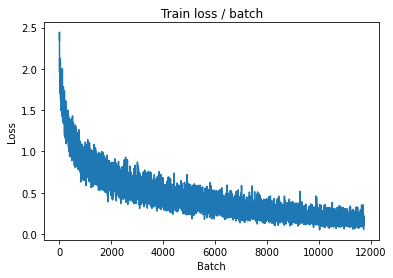

[TRAIN Batch 200/391]	Time 0.017s (0.040s)	Loss 0.1716 (0.1592)	Prec@1  93.8 ( 94.4)	Prec@5 100.0 (100.0)


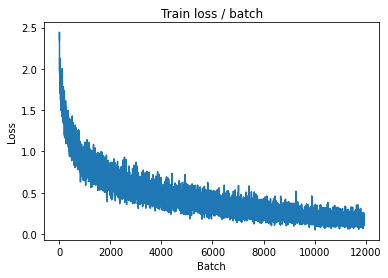


===============> Total time 15s	Avg loss 0.1618	Avg Prec@1 94.40 %	Avg Prec@5 99.93 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 0.4940 (0.4940)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5585	Avg Prec@1 84.49 %	Avg Prec@5 99.19 %



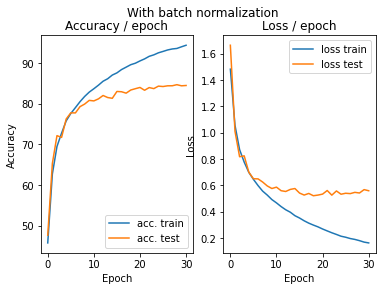

=== EPOCH 32 =====

[TRAIN Batch 000/391]	Time 0.191s (0.191s)	Loss 0.1768 (0.1768)	Prec@1  94.5 ( 94.5)	Prec@5  99.2 ( 99.2)


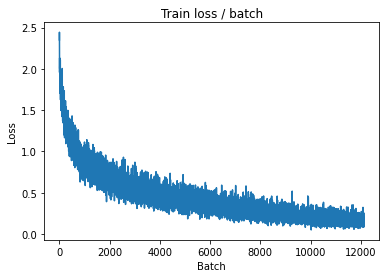

[TRAIN Batch 200/391]	Time 0.045s (0.039s)	Loss 0.1338 (0.1537)	Prec@1  96.1 ( 94.7)	Prec@5 100.0 ( 99.9)


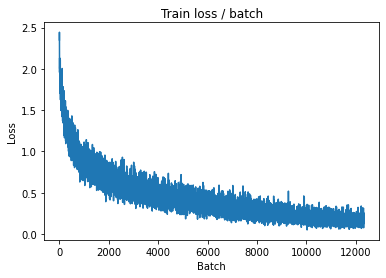


===============> Total time 14s	Avg loss 0.1551	Avg Prec@1 94.62 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.4919 (0.4919)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5452	Avg Prec@1 84.46 %	Avg Prec@5 99.28 %



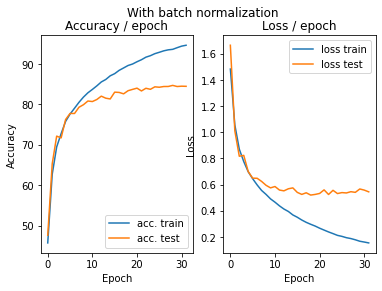

=== EPOCH 33 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 0.1480 (0.1480)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


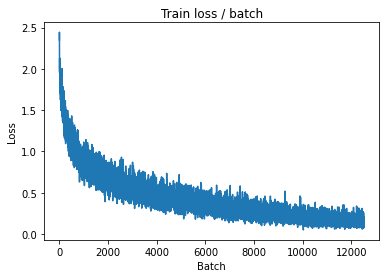

[TRAIN Batch 200/391]	Time 0.011s (0.038s)	Loss 0.1945 (0.1433)	Prec@1  93.0 ( 95.1)	Prec@5 100.0 ( 99.9)


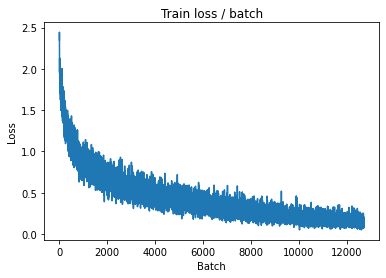


===============> Total time 14s	Avg loss 0.1472	Avg Prec@1 94.86 %	Avg Prec@5 99.95 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.4781 (0.4781)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5519	Avg Prec@1 84.67 %	Avg Prec@5 99.19 %



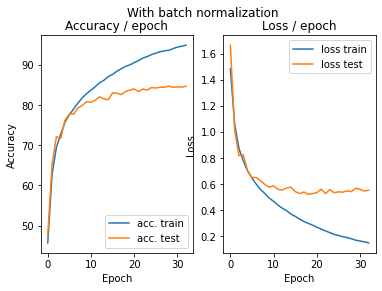

=== EPOCH 34 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.1832 (0.1832)	Prec@1  93.8 ( 93.8)	Prec@5 100.0 (100.0)


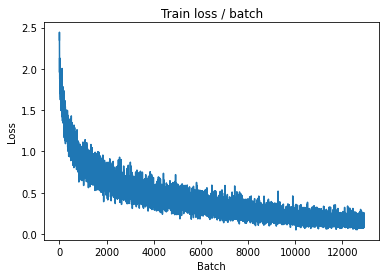

[TRAIN Batch 200/391]	Time 0.057s (0.040s)	Loss 0.0823 (0.1398)	Prec@1  98.4 ( 95.2)	Prec@5 100.0 (100.0)


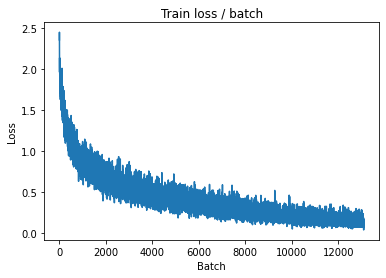


===============> Total time 15s	Avg loss 0.1399	Avg Prec@1 95.16 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.5058 (0.5058)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5549	Avg Prec@1 84.77 %	Avg Prec@5 99.24 %



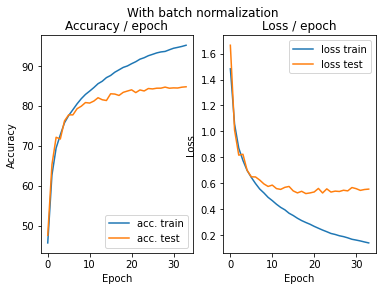

=== EPOCH 35 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 0.1334 (0.1334)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


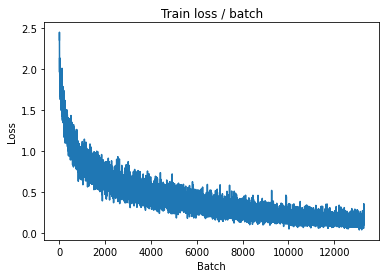

[TRAIN Batch 200/391]	Time 0.056s (0.038s)	Loss 0.0606 (0.1270)	Prec@1  97.7 ( 95.6)	Prec@5 100.0 (100.0)


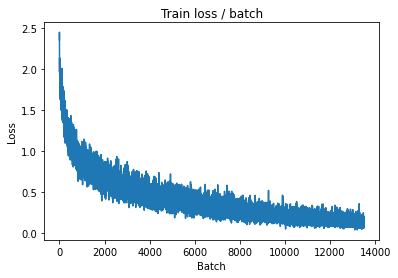


===============> Total time 14s	Avg loss 0.1305	Avg Prec@1 95.46 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 0.4660 (0.4660)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5637	Avg Prec@1 84.70 %	Avg Prec@5 99.24 %



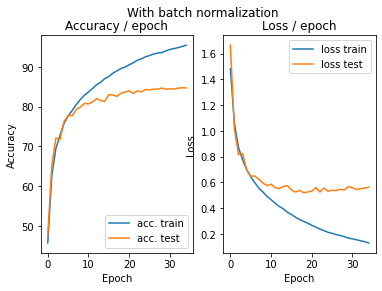

=== EPOCH 36 =====

[TRAIN Batch 000/391]	Time 0.180s (0.180s)	Loss 0.1156 (0.1156)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


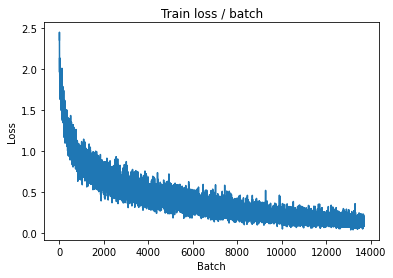

[TRAIN Batch 200/391]	Time 0.040s (0.037s)	Loss 0.0874 (0.1225)	Prec@1  96.9 ( 95.7)	Prec@5 100.0 (100.0)


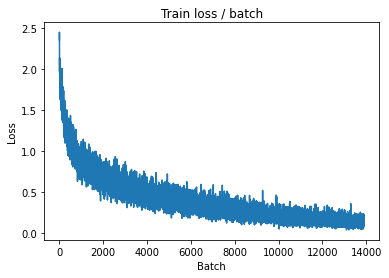


===============> Total time 14s	Avg loss 0.1254	Avg Prec@1 95.61 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.4839 (0.4839)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5726	Avg Prec@1 84.78 %	Avg Prec@5 99.27 %



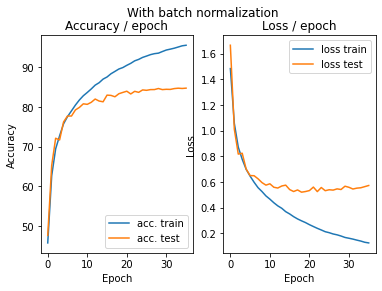

=== EPOCH 37 =====

[TRAIN Batch 000/391]	Time 0.167s (0.167s)	Loss 0.1761 (0.1761)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


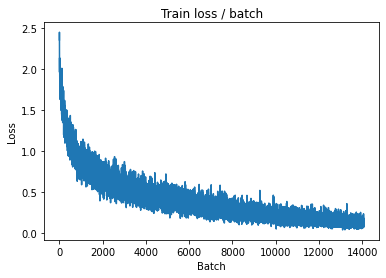

[TRAIN Batch 200/391]	Time 0.050s (0.039s)	Loss 0.1042 (0.1171)	Prec@1  96.9 ( 95.9)	Prec@5 100.0 (100.0)


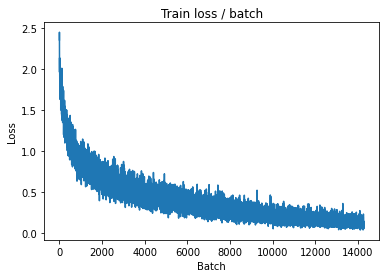


===============> Total time 15s	Avg loss 0.1214	Avg Prec@1 95.78 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.5587 (0.5587)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5684	Avg Prec@1 84.65 %	Avg Prec@5 99.27 %



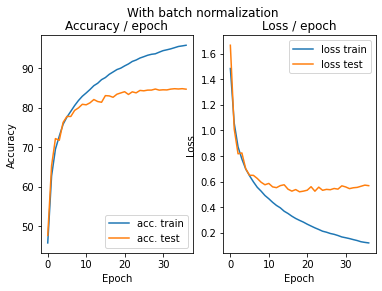

=== EPOCH 38 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.1209 (0.1209)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


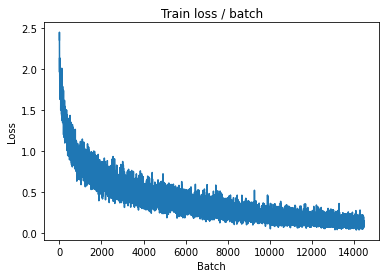

[TRAIN Batch 200/391]	Time 0.046s (0.039s)	Loss 0.1280 (0.1127)	Prec@1  96.9 ( 96.0)	Prec@5 100.0 (100.0)


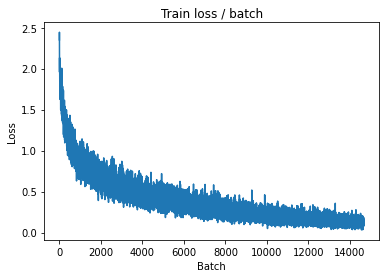


===============> Total time 15s	Avg loss 0.1144	Avg Prec@1 96.01 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.5000 (0.5000)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5747	Avg Prec@1 85.06 %	Avg Prec@5 99.13 %



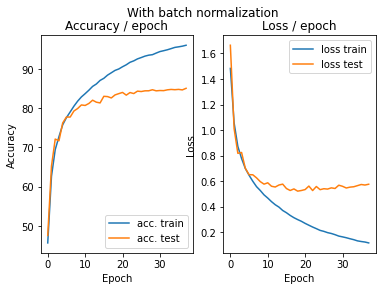

=== EPOCH 39 =====

[TRAIN Batch 000/391]	Time 0.154s (0.154s)	Loss 0.1104 (0.1104)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


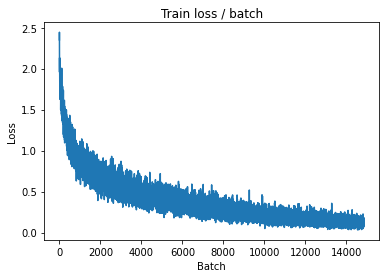

[TRAIN Batch 200/391]	Time 0.067s (0.040s)	Loss 0.0718 (0.1099)	Prec@1  97.7 ( 96.2)	Prec@5 100.0 (100.0)


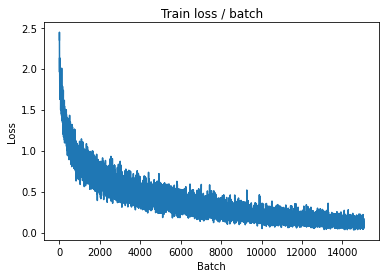


===============> Total time 15s	Avg loss 0.1122	Avg Prec@1 96.15 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.4771 (0.4771)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5745	Avg Prec@1 84.82 %	Avg Prec@5 99.25 %



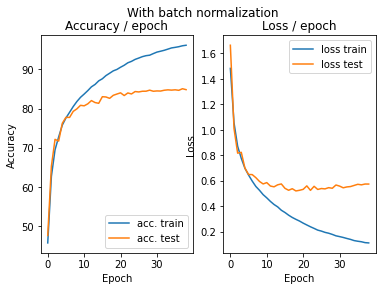

=== EPOCH 40 =====

[TRAIN Batch 000/391]	Time 0.199s (0.199s)	Loss 0.0912 (0.0912)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


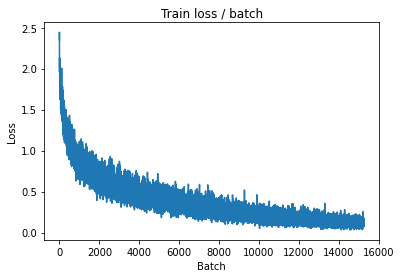

[TRAIN Batch 200/391]	Time 0.022s (0.040s)	Loss 0.2001 (0.1059)	Prec@1  94.5 ( 96.3)	Prec@5 100.0 (100.0)


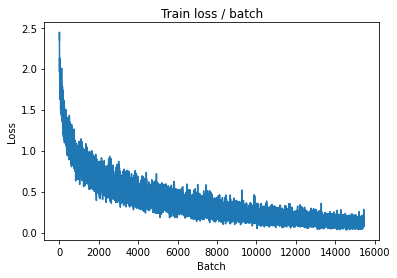


===============> Total time 15s	Avg loss 0.1066	Avg Prec@1 96.36 %	Avg Prec@5 99.97 %

[EVAL Batch 000/079]	Time 0.166s (0.166s)	Loss 0.5216 (0.5216)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5816	Avg Prec@1 85.19 %	Avg Prec@5 99.30 %



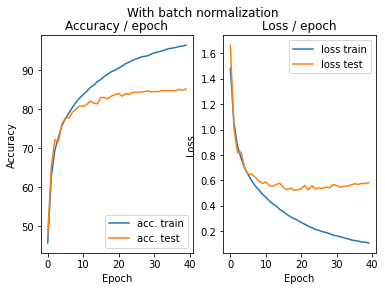

=== EPOCH 41 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.1266 (0.1266)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


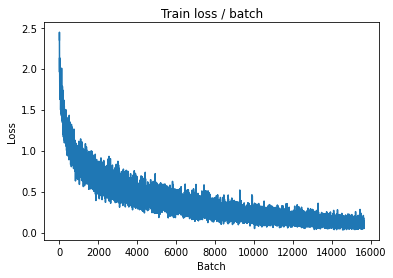

[TRAIN Batch 200/391]	Time 0.037s (0.039s)	Loss 0.1047 (0.1065)	Prec@1  97.7 ( 96.3)	Prec@5 100.0 (100.0)


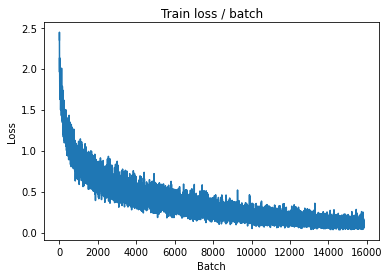


===============> Total time 15s	Avg loss 0.1068	Avg Prec@1 96.31 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.4728 (0.4728)	Prec@1  86.7 ( 86.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5687	Avg Prec@1 84.89 %	Avg Prec@5 99.30 %



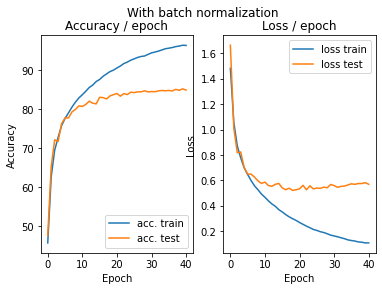

=== EPOCH 42 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.0999 (0.0999)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


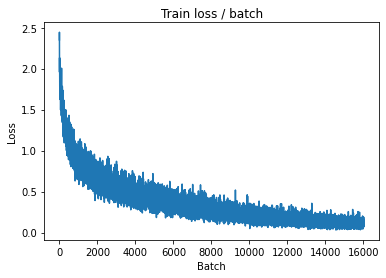

[TRAIN Batch 200/391]	Time 0.017s (0.039s)	Loss 0.1066 (0.0984)	Prec@1  97.7 ( 96.6)	Prec@5 100.0 (100.0)


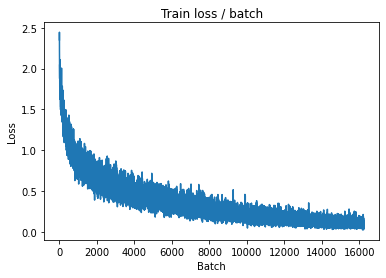


===============> Total time 15s	Avg loss 0.0994	Avg Prec@1 96.59 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.4704 (0.4704)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5778	Avg Prec@1 84.93 %	Avg Prec@5 99.26 %



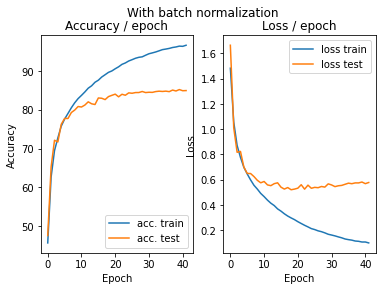

=== EPOCH 43 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.1227 (0.1227)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


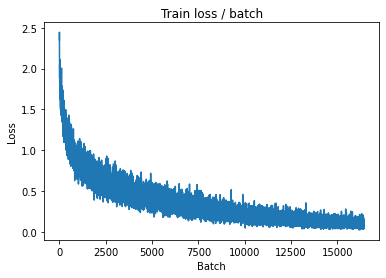

[TRAIN Batch 200/391]	Time 0.047s (0.039s)	Loss 0.0717 (0.0980)	Prec@1  96.9 ( 96.6)	Prec@5 100.0 (100.0)


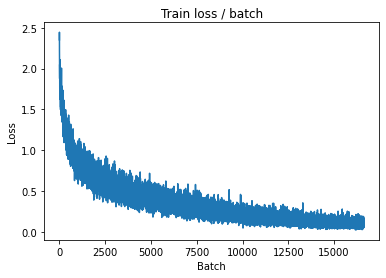


===============> Total time 15s	Avg loss 0.0979	Avg Prec@1 96.63 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.144s (0.144s)	Loss 0.4911 (0.4911)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5790	Avg Prec@1 85.13 %	Avg Prec@5 99.23 %



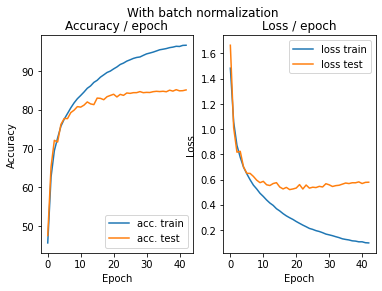

=== EPOCH 44 =====

[TRAIN Batch 000/391]	Time 0.197s (0.197s)	Loss 0.1028 (0.1028)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


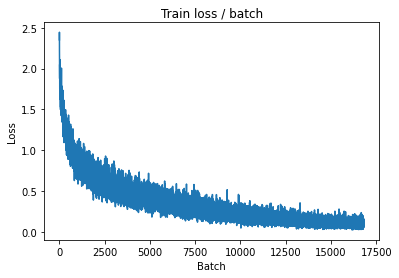

[TRAIN Batch 200/391]	Time 0.016s (0.039s)	Loss 0.0612 (0.0886)	Prec@1  97.7 ( 97.0)	Prec@5 100.0 (100.0)


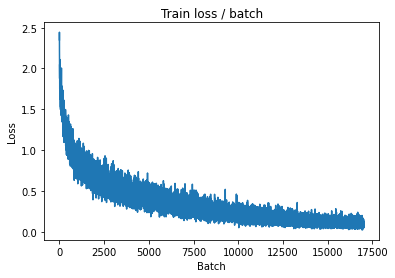


===============> Total time 15s	Avg loss 0.0919	Avg Prec@1 96.90 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.4680 (0.4680)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.5876	Avg Prec@1 84.96 %	Avg Prec@5 99.26 %



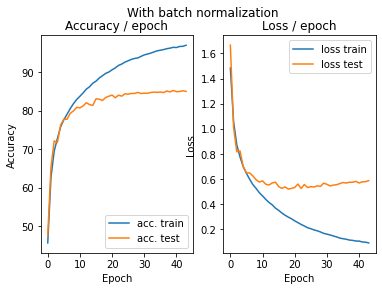

=== EPOCH 45 =====

[TRAIN Batch 000/391]	Time 0.177s (0.177s)	Loss 0.0641 (0.0641)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


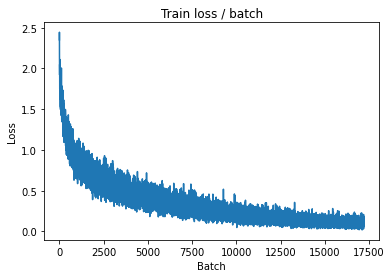

[TRAIN Batch 200/391]	Time 0.044s (0.038s)	Loss 0.0806 (0.0840)	Prec@1  97.7 ( 97.2)	Prec@5 100.0 (100.0)


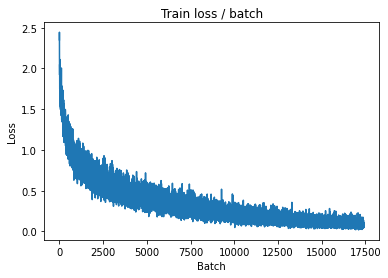


===============> Total time 14s	Avg loss 0.0873	Avg Prec@1 97.03 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.4337 (0.4337)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5819	Avg Prec@1 85.27 %	Avg Prec@5 99.26 %



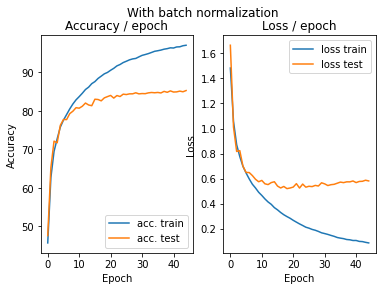

=== EPOCH 46 =====

[TRAIN Batch 000/391]	Time 0.168s (0.168s)	Loss 0.0773 (0.0773)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


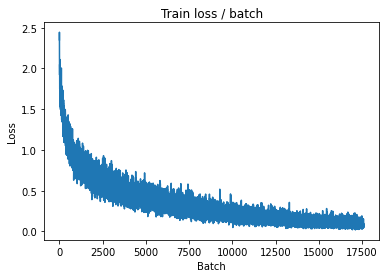

[TRAIN Batch 200/391]	Time 0.066s (0.038s)	Loss 0.1788 (0.0861)	Prec@1  93.0 ( 97.1)	Prec@5 100.0 (100.0)


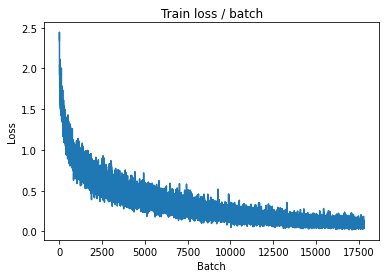


===============> Total time 14s	Avg loss 0.0857	Avg Prec@1 97.10 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.4883 (0.4883)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5898	Avg Prec@1 85.41 %	Avg Prec@5 99.26 %



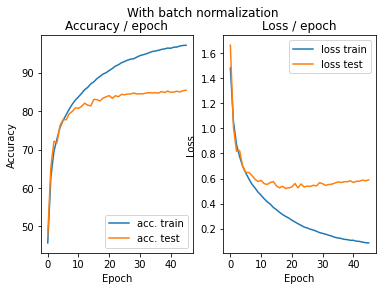

=== EPOCH 47 =====

[TRAIN Batch 000/391]	Time 0.197s (0.197s)	Loss 0.1276 (0.1276)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


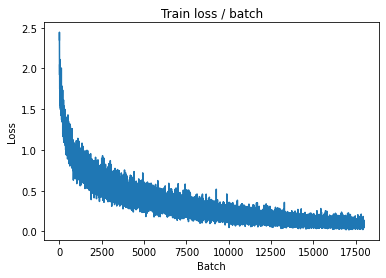

[TRAIN Batch 200/391]	Time 0.050s (0.038s)	Loss 0.0904 (0.0835)	Prec@1  98.4 ( 97.2)	Prec@5  99.2 (100.0)


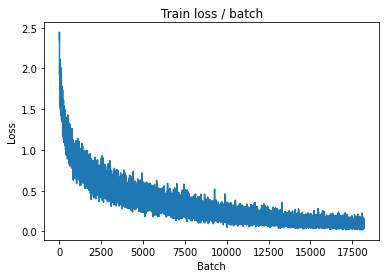


===============> Total time 15s	Avg loss 0.0844	Avg Prec@1 97.13 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.4736 (0.4736)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5905	Avg Prec@1 85.40 %	Avg Prec@5 99.19 %



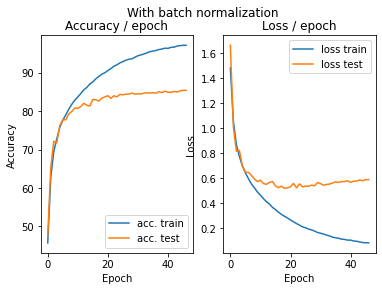

=== EPOCH 48 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.0417 (0.0417)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


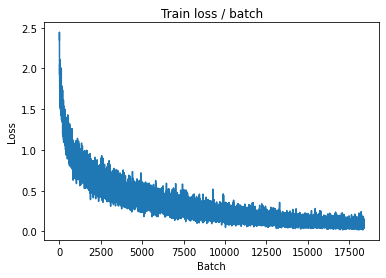

[TRAIN Batch 200/391]	Time 0.022s (0.038s)	Loss 0.0449 (0.0810)	Prec@1  98.4 ( 97.3)	Prec@5 100.0 (100.0)


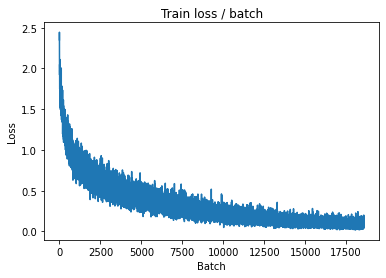


===============> Total time 14s	Avg loss 0.0809	Avg Prec@1 97.30 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.4718 (0.4718)	Prec@1  89.1 ( 89.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5868	Avg Prec@1 85.51 %	Avg Prec@5 99.25 %



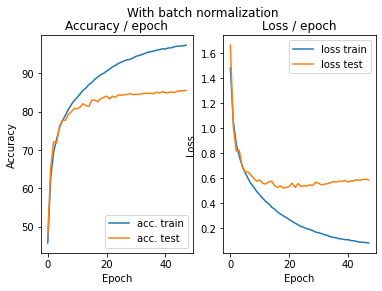

=== EPOCH 49 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 0.0864 (0.0864)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


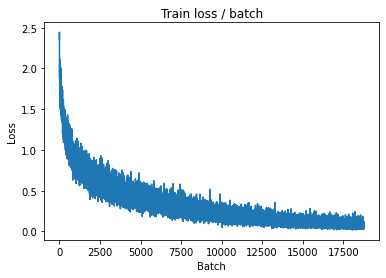

[TRAIN Batch 200/391]	Time 0.053s (0.038s)	Loss 0.0298 (0.0774)	Prec@1 100.0 ( 97.5)	Prec@5 100.0 (100.0)


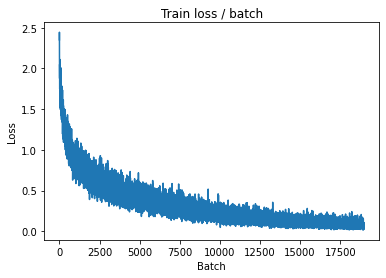


===============> Total time 15s	Avg loss 0.0785	Avg Prec@1 97.40 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.4220 (0.4220)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5966	Avg Prec@1 85.78 %	Avg Prec@5 99.21 %



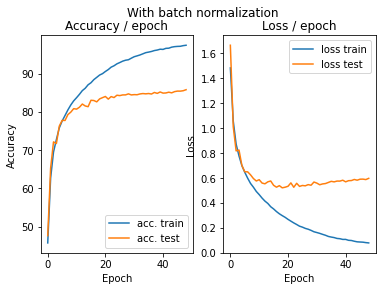

=== EPOCH 50 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.0717 (0.0717)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


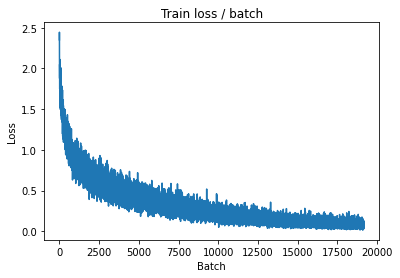

[TRAIN Batch 200/391]	Time 0.062s (0.040s)	Loss 0.0503 (0.0747)	Prec@1  99.2 ( 97.5)	Prec@5 100.0 (100.0)


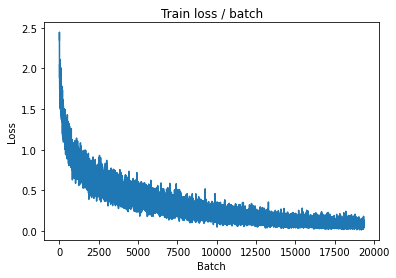


===============> Total time 15s	Avg loss 0.0745	Avg Prec@1 97.44 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.4662 (0.4662)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5953	Avg Prec@1 85.68 %	Avg Prec@5 99.26 %



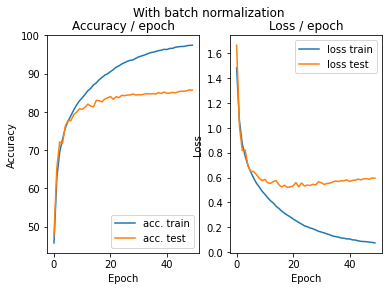

=== EPOCH 51 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 0.0776 (0.0776)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


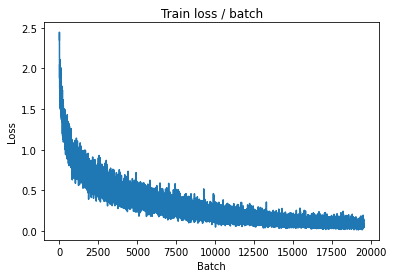

[TRAIN Batch 200/391]	Time 0.052s (0.040s)	Loss 0.0899 (0.0713)	Prec@1  97.7 ( 97.6)	Prec@5 100.0 (100.0)


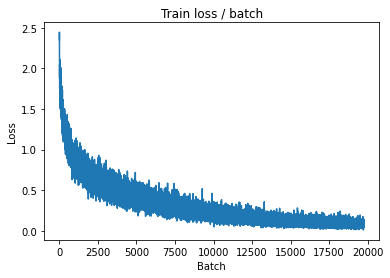


===============> Total time 15s	Avg loss 0.0741	Avg Prec@1 97.52 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.4778 (0.4778)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5919	Avg Prec@1 85.60 %	Avg Prec@5 99.23 %



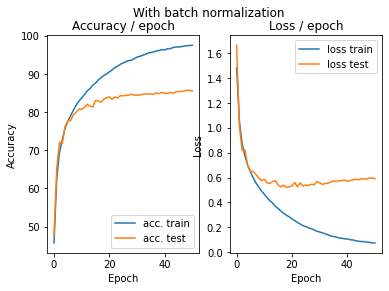

=== EPOCH 52 =====

[TRAIN Batch 000/391]	Time 0.203s (0.203s)	Loss 0.0986 (0.0986)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


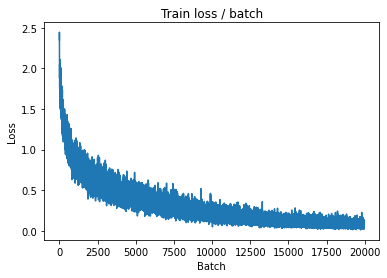

[TRAIN Batch 200/391]	Time 0.025s (0.040s)	Loss 0.1248 (0.0679)	Prec@1  93.8 ( 97.7)	Prec@5 100.0 (100.0)


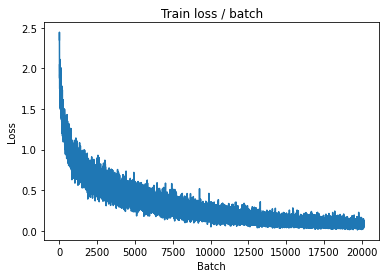


===============> Total time 15s	Avg loss 0.0706	Avg Prec@1 97.63 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.4311 (0.4311)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5986	Avg Prec@1 85.87 %	Avg Prec@5 99.26 %



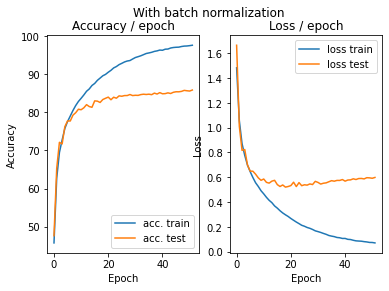

=== EPOCH 53 =====

[TRAIN Batch 000/391]	Time 0.204s (0.204s)	Loss 0.0798 (0.0798)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


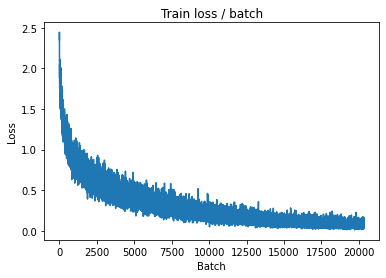

[TRAIN Batch 200/391]	Time 0.047s (0.038s)	Loss 0.0241 (0.0672)	Prec@1  99.2 ( 97.8)	Prec@5 100.0 (100.0)


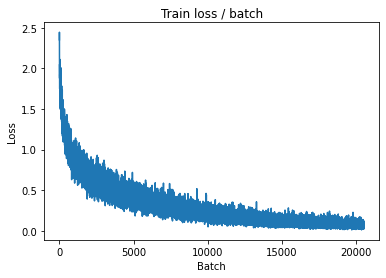


===============> Total time 14s	Avg loss 0.0671	Avg Prec@1 97.79 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.4643 (0.4643)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6059	Avg Prec@1 85.76 %	Avg Prec@5 99.27 %



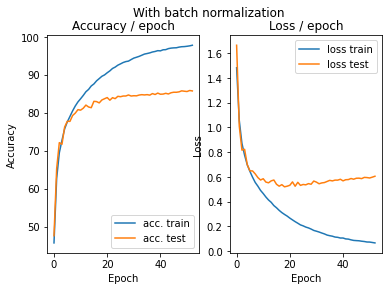

=== EPOCH 54 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.0369 (0.0369)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


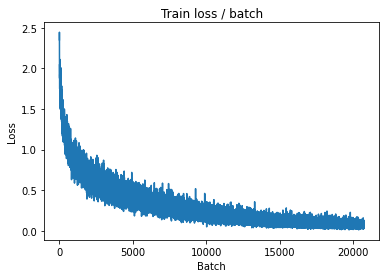

[TRAIN Batch 200/391]	Time 0.047s (0.039s)	Loss 0.0620 (0.0672)	Prec@1  96.9 ( 97.8)	Prec@5 100.0 (100.0)


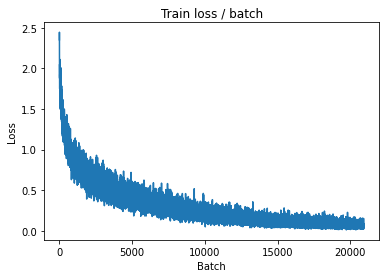


===============> Total time 15s	Avg loss 0.0682	Avg Prec@1 97.75 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.4650 (0.4650)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.6042	Avg Prec@1 85.78 %	Avg Prec@5 99.28 %



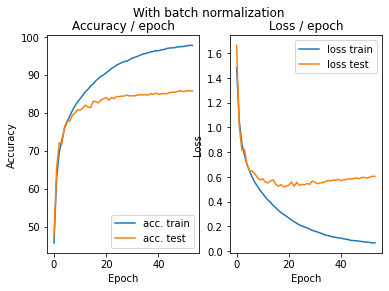

=== EPOCH 55 =====

[TRAIN Batch 000/391]	Time 0.181s (0.181s)	Loss 0.0879 (0.0879)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


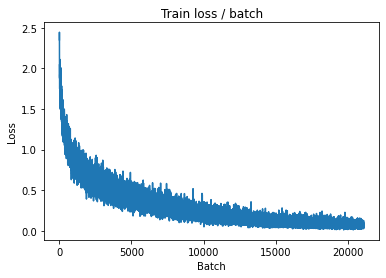

[TRAIN Batch 200/391]	Time 0.016s (0.038s)	Loss 0.0749 (0.0653)	Prec@1  97.7 ( 97.8)	Prec@5 100.0 (100.0)


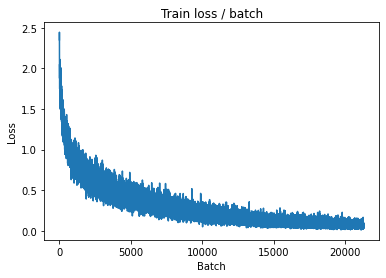


===============> Total time 14s	Avg loss 0.0642	Avg Prec@1 97.82 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.4769 (0.4769)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6062	Avg Prec@1 85.87 %	Avg Prec@5 99.21 %



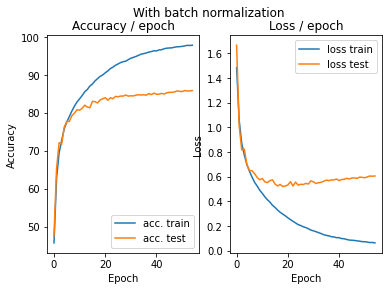

=== EPOCH 56 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.0748 (0.0748)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


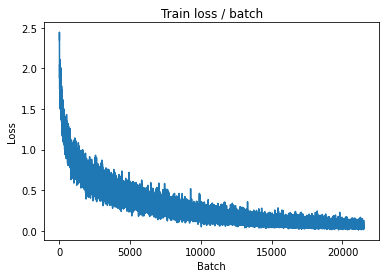

[TRAIN Batch 200/391]	Time 0.012s (0.039s)	Loss 0.0324 (0.0636)	Prec@1  99.2 ( 97.9)	Prec@5 100.0 (100.0)


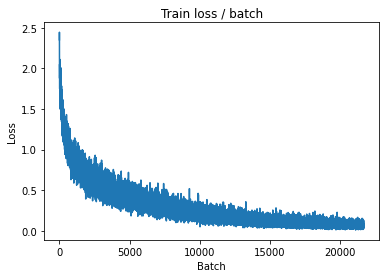


===============> Total time 14s	Avg loss 0.0674	Avg Prec@1 97.67 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.4990 (0.4990)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6069	Avg Prec@1 85.78 %	Avg Prec@5 99.23 %



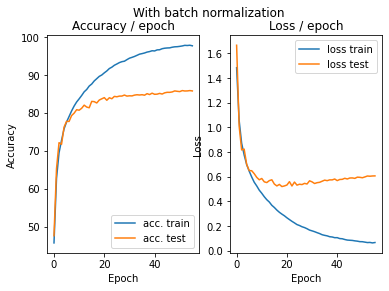

=== EPOCH 57 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.0871 (0.0871)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


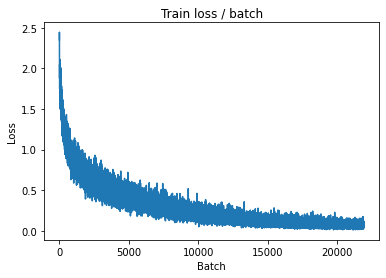

[TRAIN Batch 200/391]	Time 0.052s (0.039s)	Loss 0.0518 (0.0625)	Prec@1  98.4 ( 98.0)	Prec@5 100.0 (100.0)


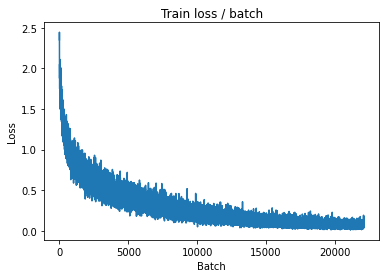


===============> Total time 15s	Avg loss 0.0643	Avg Prec@1 97.92 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.4845 (0.4845)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6024	Avg Prec@1 85.34 %	Avg Prec@5 99.24 %



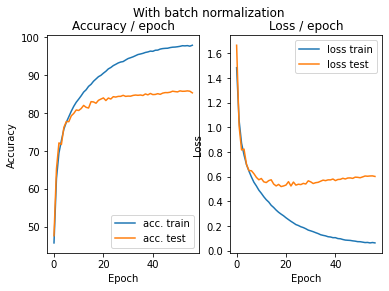

=== EPOCH 58 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.0466 (0.0466)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


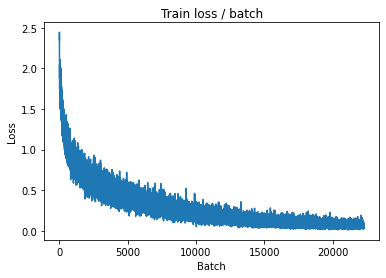

[TRAIN Batch 200/391]	Time 0.023s (0.036s)	Loss 0.0982 (0.0597)	Prec@1  97.7 ( 98.0)	Prec@5 100.0 (100.0)


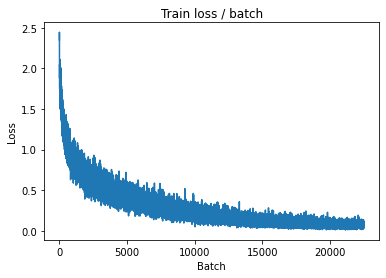


===============> Total time 14s	Avg loss 0.0594	Avg Prec@1 98.03 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.4703 (0.4703)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6069	Avg Prec@1 85.86 %	Avg Prec@5 99.29 %



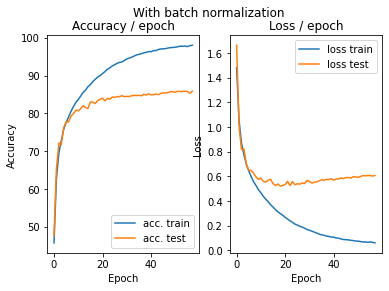

=== EPOCH 59 =====

[TRAIN Batch 000/391]	Time 0.206s (0.206s)	Loss 0.1071 (0.1071)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


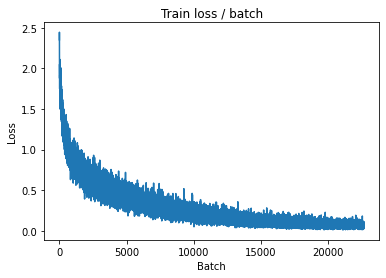

[TRAIN Batch 200/391]	Time 0.013s (0.038s)	Loss 0.0634 (0.0605)	Prec@1  97.7 ( 98.1)	Prec@5 100.0 (100.0)


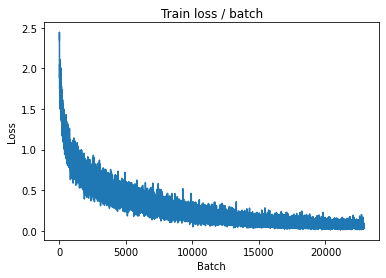


===============> Total time 14s	Avg loss 0.0598	Avg Prec@1 98.06 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.5015 (0.5015)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)

===============> Total time 2s	Avg loss 0.6110	Avg Prec@1 85.69 %	Avg Prec@5 99.33 %



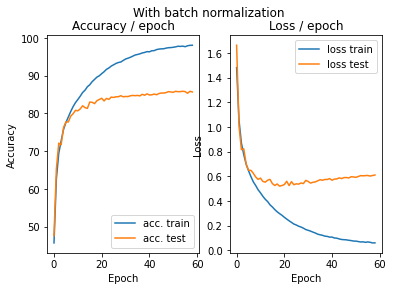

=== EPOCH 60 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.0745 (0.0745)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


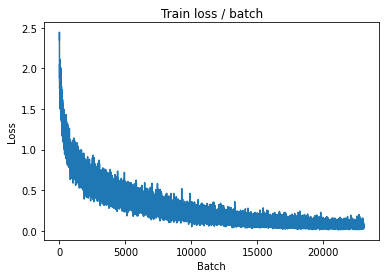

[TRAIN Batch 200/391]	Time 0.045s (0.038s)	Loss 0.0754 (0.0604)	Prec@1  98.4 ( 98.0)	Prec@5 100.0 (100.0)


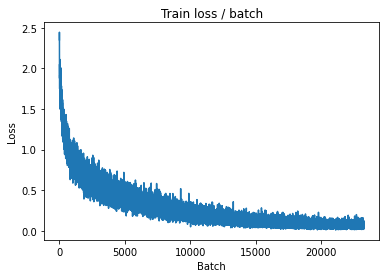


===============> Total time 14s	Avg loss 0.0593	Avg Prec@1 98.01 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.167s (0.167s)	Loss 0.4869 (0.4869)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6098	Avg Prec@1 85.84 %	Avg Prec@5 99.30 %



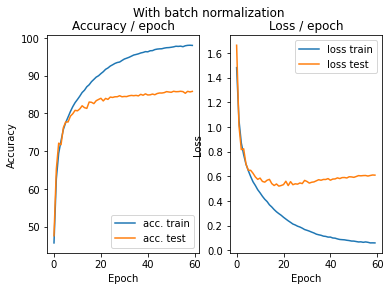

=== EPOCH 61 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.0627 (0.0627)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


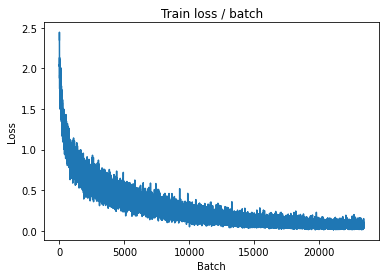

[TRAIN Batch 200/391]	Time 0.041s (0.038s)	Loss 0.0603 (0.0606)	Prec@1  97.7 ( 98.1)	Prec@5 100.0 (100.0)


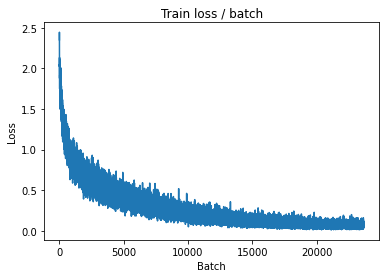


===============> Total time 14s	Avg loss 0.0574	Avg Prec@1 98.14 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.4723 (0.4723)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6107	Avg Prec@1 85.79 %	Avg Prec@5 99.33 %



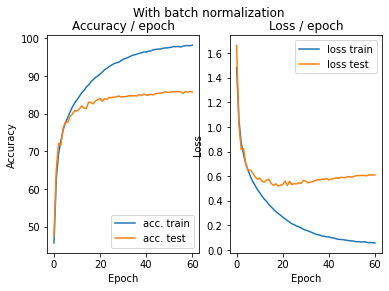

=== EPOCH 62 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 0.1027 (0.1027)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


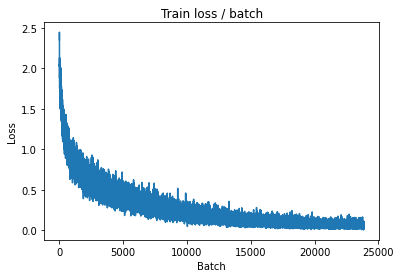

[TRAIN Batch 200/391]	Time 0.034s (0.038s)	Loss 0.0318 (0.0592)	Prec@1  99.2 ( 98.1)	Prec@5 100.0 (100.0)


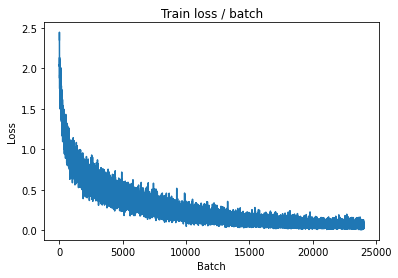


===============> Total time 14s	Avg loss 0.0599	Avg Prec@1 98.08 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 0.4981 (0.4981)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6071	Avg Prec@1 85.87 %	Avg Prec@5 99.29 %



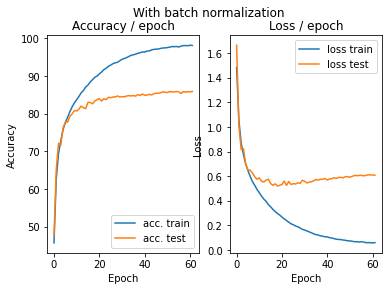

=== EPOCH 63 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.0721 (0.0721)	Prec@1  96.1 ( 96.1)	Prec@5 100.0 (100.0)


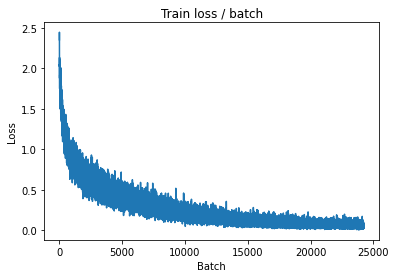

[TRAIN Batch 200/391]	Time 0.070s (0.039s)	Loss 0.0637 (0.0547)	Prec@1  96.9 ( 98.2)	Prec@5 100.0 (100.0)


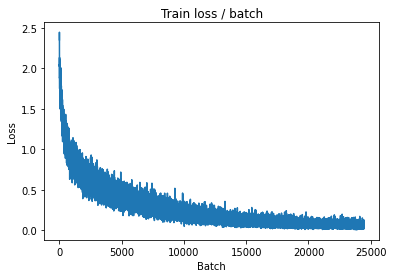


===============> Total time 14s	Avg loss 0.0550	Avg Prec@1 98.20 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.145s (0.145s)	Loss 0.4952 (0.4952)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6169	Avg Prec@1 85.61 %	Avg Prec@5 99.30 %



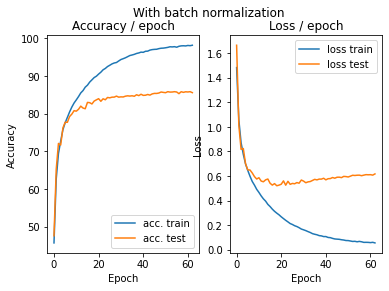

=== EPOCH 64 =====

[TRAIN Batch 000/391]	Time 0.172s (0.172s)	Loss 0.0896 (0.0896)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


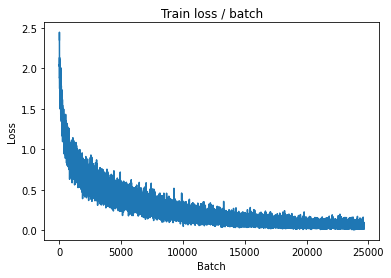

[TRAIN Batch 200/391]	Time 0.021s (0.039s)	Loss 0.0501 (0.0559)	Prec@1  97.7 ( 98.2)	Prec@5 100.0 (100.0)


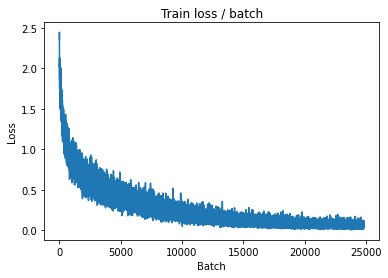


===============> Total time 14s	Avg loss 0.0569	Avg Prec@1 98.13 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 0.5310 (0.5310)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6191	Avg Prec@1 85.78 %	Avg Prec@5 99.31 %



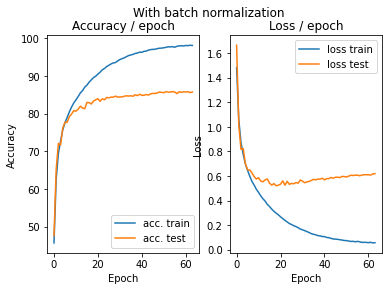

=== EPOCH 65 =====

[TRAIN Batch 000/391]	Time 0.173s (0.173s)	Loss 0.0402 (0.0402)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


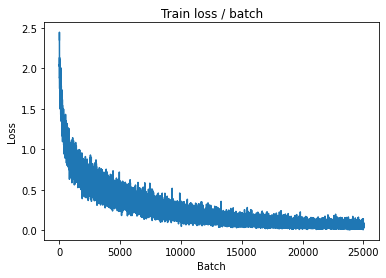

[TRAIN Batch 200/391]	Time 0.023s (0.038s)	Loss 0.0523 (0.0549)	Prec@1  98.4 ( 98.2)	Prec@5 100.0 (100.0)


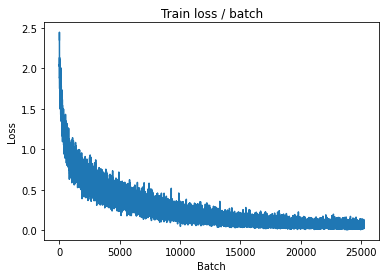


===============> Total time 14s	Avg loss 0.0560	Avg Prec@1 98.18 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 0.5052 (0.5052)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6197	Avg Prec@1 85.61 %	Avg Prec@5 99.19 %



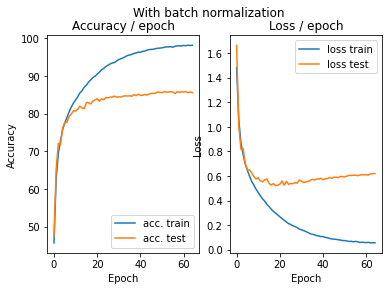

=== EPOCH 66 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.0434 (0.0434)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


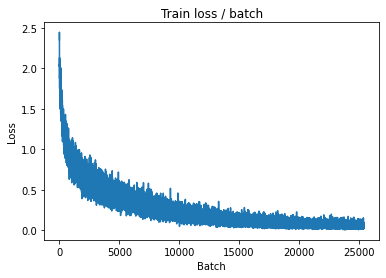

[TRAIN Batch 200/391]	Time 0.060s (0.037s)	Loss 0.0422 (0.0514)	Prec@1  97.7 ( 98.4)	Prec@5 100.0 (100.0)


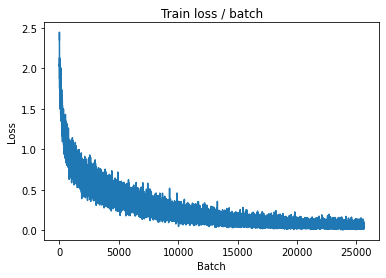


===============> Total time 14s	Avg loss 0.0524	Avg Prec@1 98.32 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.5087 (0.5087)	Prec@1  87.5 ( 87.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6143	Avg Prec@1 85.70 %	Avg Prec@5 99.27 %



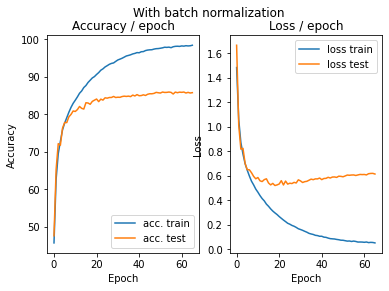

=== EPOCH 67 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.1059 (0.1059)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


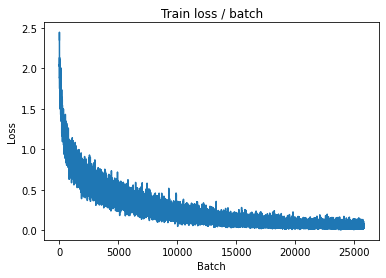

[TRAIN Batch 200/391]	Time 0.068s (0.038s)	Loss 0.0274 (0.0524)	Prec@1 100.0 ( 98.3)	Prec@5 100.0 (100.0)


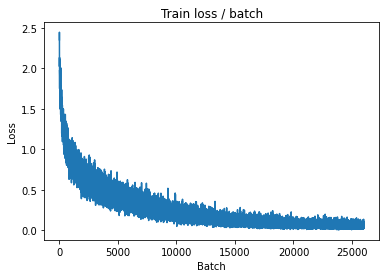


===============> Total time 14s	Avg loss 0.0520	Avg Prec@1 98.31 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.4981 (0.4981)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6261	Avg Prec@1 85.78 %	Avg Prec@5 99.29 %



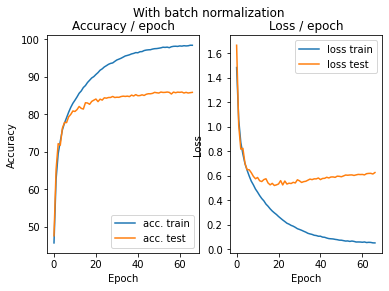

=== EPOCH 68 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 0.0664 (0.0664)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


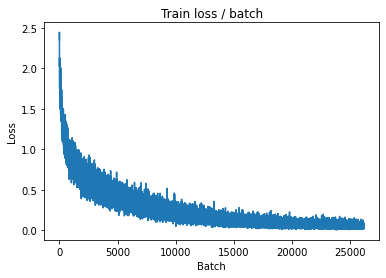

[TRAIN Batch 200/391]	Time 0.067s (0.038s)	Loss 0.0824 (0.0536)	Prec@1  97.7 ( 98.3)	Prec@5 100.0 (100.0)


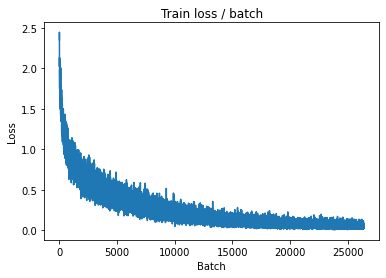


===============> Total time 14s	Avg loss 0.0538	Avg Prec@1 98.23 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.4949 (0.4949)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6216	Avg Prec@1 85.75 %	Avg Prec@5 99.29 %



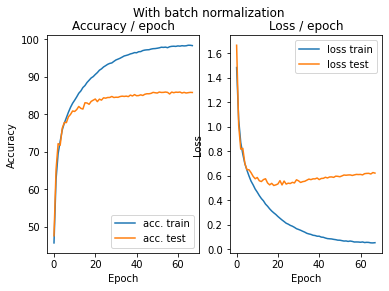

=== EPOCH 69 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.0186 (0.0186)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


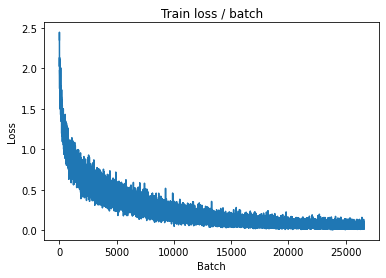

[TRAIN Batch 200/391]	Time 0.055s (0.038s)	Loss 0.0502 (0.0522)	Prec@1  98.4 ( 98.3)	Prec@5 100.0 (100.0)


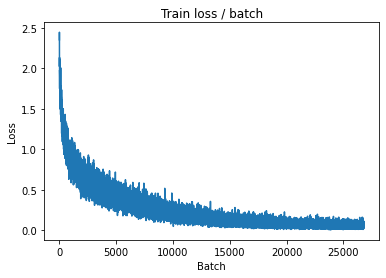


===============> Total time 14s	Avg loss 0.0525	Avg Prec@1 98.28 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.144s (0.144s)	Loss 0.4712 (0.4712)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6241	Avg Prec@1 85.78 %	Avg Prec@5 99.32 %



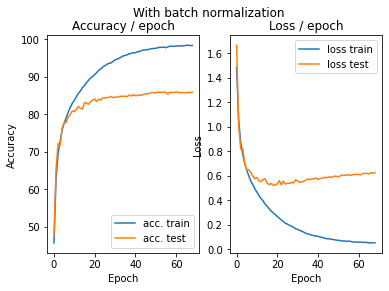

=== EPOCH 70 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.0479 (0.0479)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


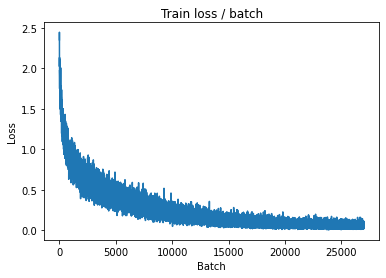

[TRAIN Batch 200/391]	Time 0.037s (0.040s)	Loss 0.0439 (0.0485)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


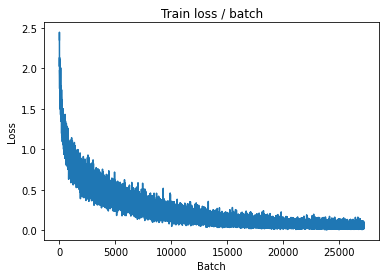


===============> Total time 14s	Avg loss 0.0494	Avg Prec@1 98.40 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.4662 (0.4662)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6180	Avg Prec@1 85.72 %	Avg Prec@5 99.32 %



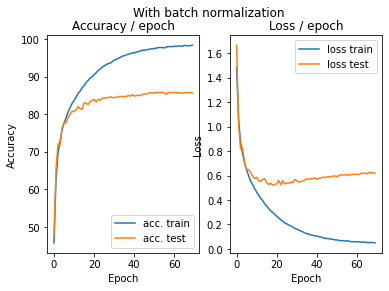

=== EPOCH 71 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.0469 (0.0469)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


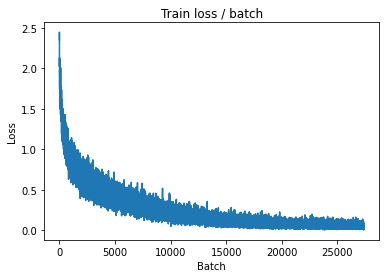

[TRAIN Batch 200/391]	Time 0.059s (0.037s)	Loss 0.0952 (0.0478)	Prec@1  97.7 ( 98.5)	Prec@5  99.2 (100.0)


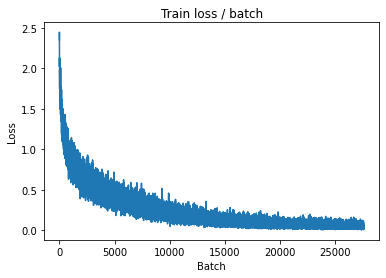


===============> Total time 14s	Avg loss 0.0476	Avg Prec@1 98.49 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.4965 (0.4965)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6232	Avg Prec@1 85.91 %	Avg Prec@5 99.32 %



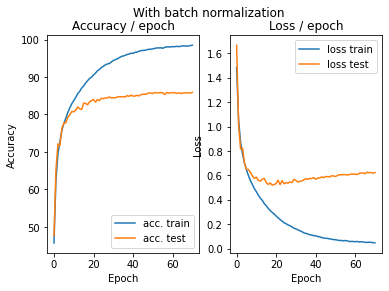

=== EPOCH 72 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 0.0295 (0.0295)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


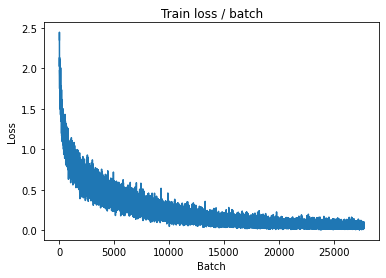

[TRAIN Batch 200/391]	Time 0.064s (0.038s)	Loss 0.0478 (0.0528)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


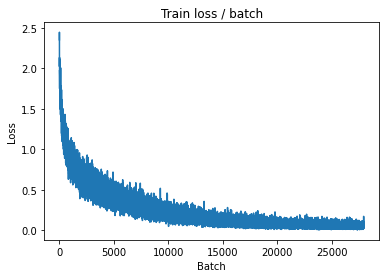


===============> Total time 14s	Avg loss 0.0516	Avg Prec@1 98.32 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.4943 (0.4943)	Prec@1  88.3 ( 88.3)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6201	Avg Prec@1 85.91 %	Avg Prec@5 99.29 %



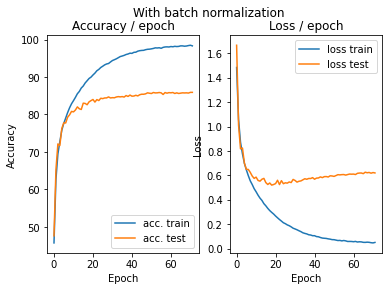

=== EPOCH 73 =====

[TRAIN Batch 000/391]	Time 0.184s (0.184s)	Loss 0.0560 (0.0560)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


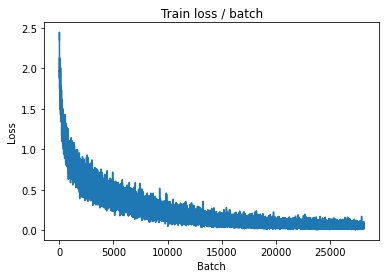

[TRAIN Batch 200/391]	Time 0.063s (0.038s)	Loss 0.0307 (0.0499)	Prec@1  99.2 ( 98.4)	Prec@5 100.0 (100.0)


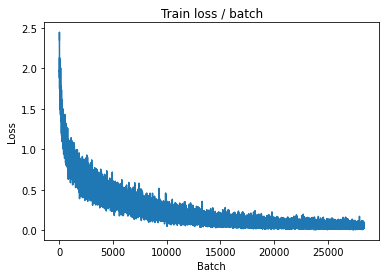


===============> Total time 14s	Avg loss 0.0489	Avg Prec@1 98.42 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.147s (0.147s)	Loss 0.5210 (0.5210)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6244	Avg Prec@1 85.85 %	Avg Prec@5 99.28 %



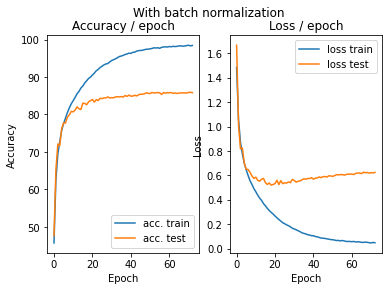

=== EPOCH 74 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.0576 (0.0576)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


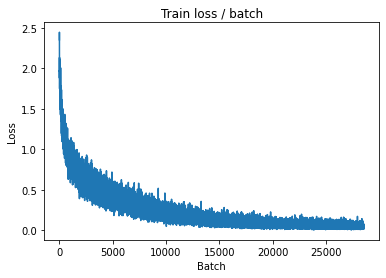

[TRAIN Batch 200/391]	Time 0.016s (0.039s)	Loss 0.0480 (0.0463)	Prec@1  98.4 ( 98.5)	Prec@5 100.0 (100.0)


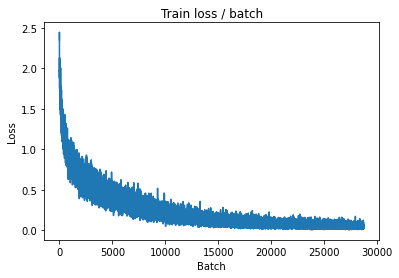


===============> Total time 15s	Avg loss 0.0478	Avg Prec@1 98.44 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.5049 (0.5049)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6269	Avg Prec@1 85.76 %	Avg Prec@5 99.26 %



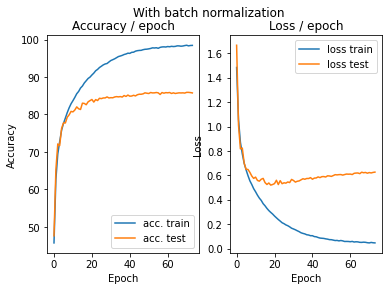

=== EPOCH 75 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.0248 (0.0248)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


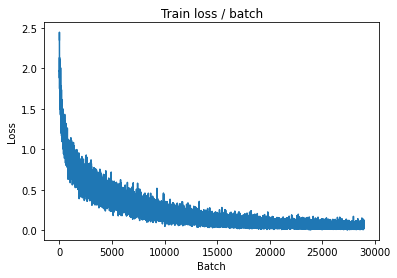

[TRAIN Batch 200/391]	Time 0.022s (0.042s)	Loss 0.0434 (0.0476)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


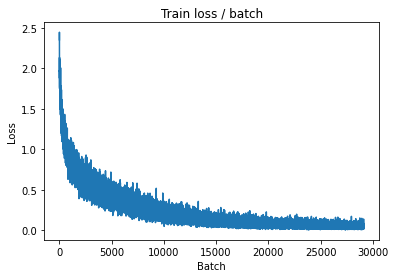


===============> Total time 15s	Avg loss 0.0471	Avg Prec@1 98.46 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.5025 (0.5025)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6224	Avg Prec@1 85.71 %	Avg Prec@5 99.33 %



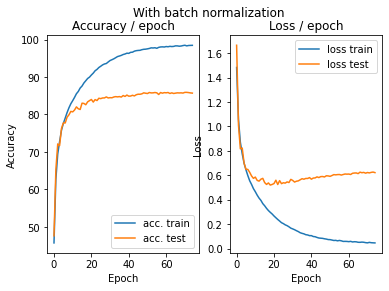

=== EPOCH 76 =====

[TRAIN Batch 000/391]	Time 0.169s (0.169s)	Loss 0.0542 (0.0542)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


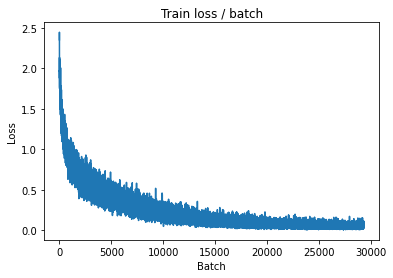

[TRAIN Batch 200/391]	Time 0.020s (0.038s)	Loss 0.0922 (0.0471)	Prec@1  96.1 ( 98.5)	Prec@5 100.0 (100.0)


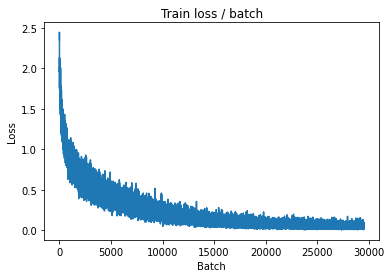


===============> Total time 14s	Avg loss 0.0469	Avg Prec@1 98.51 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.5041 (0.5041)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6245	Avg Prec@1 85.85 %	Avg Prec@5 99.32 %



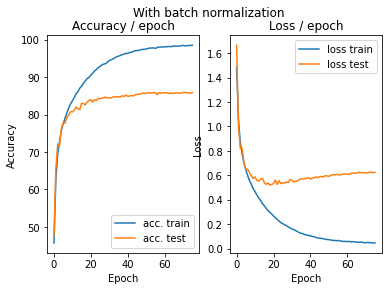

=== EPOCH 77 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.0434 (0.0434)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


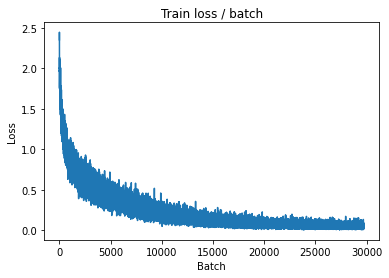

[TRAIN Batch 200/391]	Time 0.015s (0.038s)	Loss 0.0691 (0.0470)	Prec@1  96.9 ( 98.5)	Prec@5 100.0 (100.0)


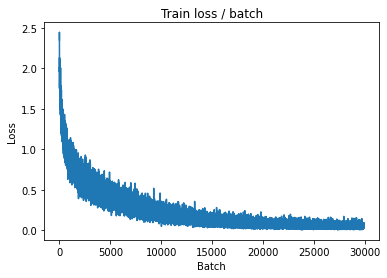


===============> Total time 14s	Avg loss 0.0472	Avg Prec@1 98.43 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.5152 (0.5152)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6292	Avg Prec@1 85.88 %	Avg Prec@5 99.30 %



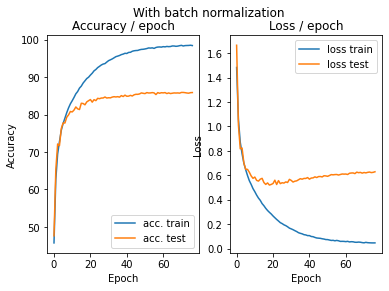

=== EPOCH 78 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 0.0543 (0.0543)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


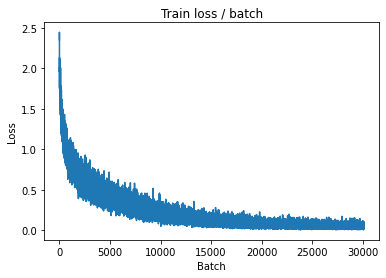

[TRAIN Batch 200/391]	Time 0.045s (0.039s)	Loss 0.0651 (0.0495)	Prec@1  97.7 ( 98.4)	Prec@5 100.0 (100.0)


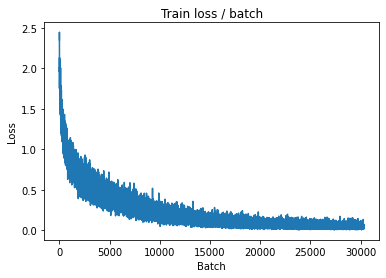


===============> Total time 15s	Avg loss 0.0499	Avg Prec@1 98.42 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.5013 (0.5013)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6262	Avg Prec@1 85.85 %	Avg Prec@5 99.30 %



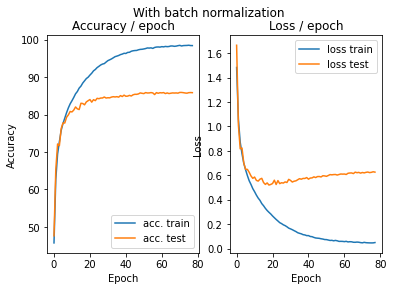

=== EPOCH 79 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.0267 (0.0267)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


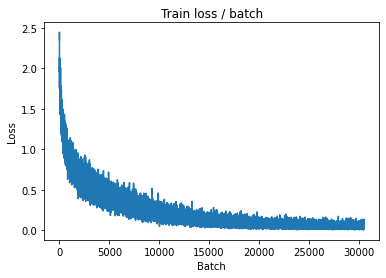

[TRAIN Batch 200/391]	Time 0.069s (0.039s)	Loss 0.1188 (0.0466)	Prec@1  94.5 ( 98.5)	Prec@5 100.0 (100.0)


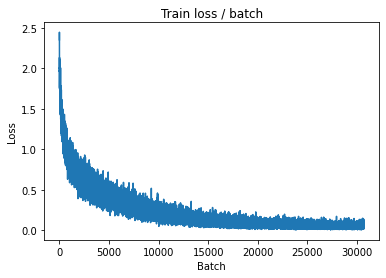


===============> Total time 14s	Avg loss 0.0474	Avg Prec@1 98.41 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.170s (0.170s)	Loss 0.4934 (0.4934)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6271	Avg Prec@1 86.02 %	Avg Prec@5 99.29 %



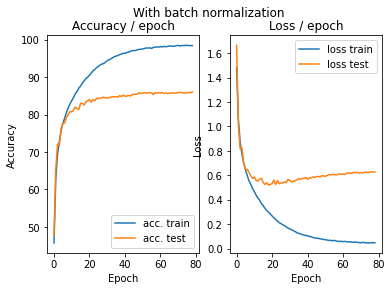

=== EPOCH 80 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.0428 (0.0428)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


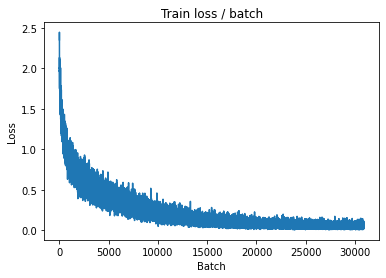

[TRAIN Batch 200/391]	Time 0.055s (0.039s)	Loss 0.0148 (0.0466)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


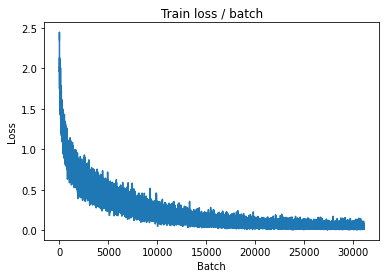


===============> Total time 15s	Avg loss 0.0470	Avg Prec@1 98.51 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.4946 (0.4946)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6291	Avg Prec@1 86.10 %	Avg Prec@5 99.27 %



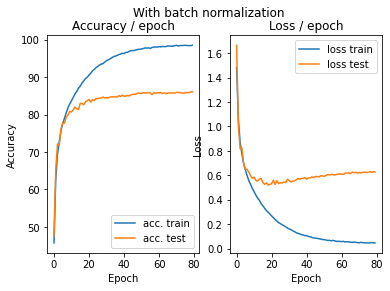

=== EPOCH 81 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.0329 (0.0329)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


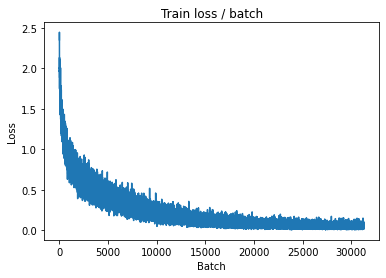

[TRAIN Batch 200/391]	Time 0.020s (0.037s)	Loss 0.0234 (0.0430)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)


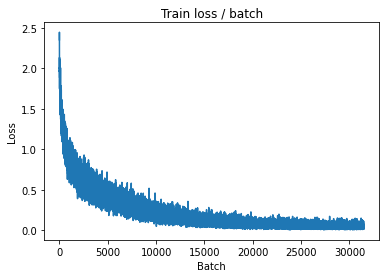


===============> Total time 14s	Avg loss 0.0440	Avg Prec@1 98.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 0.5202 (0.5202)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6290	Avg Prec@1 85.87 %	Avg Prec@5 99.30 %



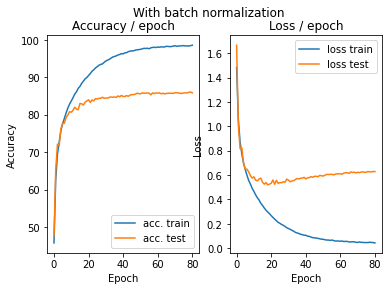

=== EPOCH 82 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.0266 (0.0266)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


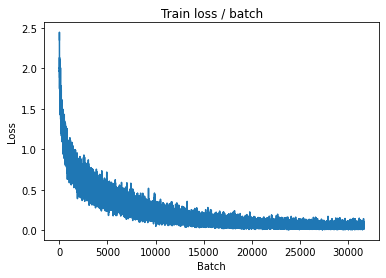

[TRAIN Batch 200/391]	Time 0.045s (0.039s)	Loss 0.0311 (0.0414)	Prec@1  98.4 ( 98.7)	Prec@5 100.0 (100.0)


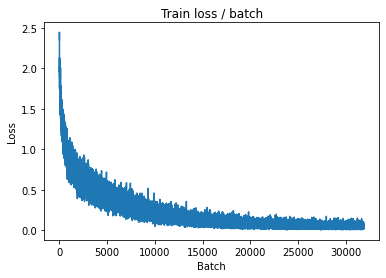


===============> Total time 14s	Avg loss 0.0431	Avg Prec@1 98.62 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.5260 (0.5260)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6299	Avg Prec@1 85.90 %	Avg Prec@5 99.23 %



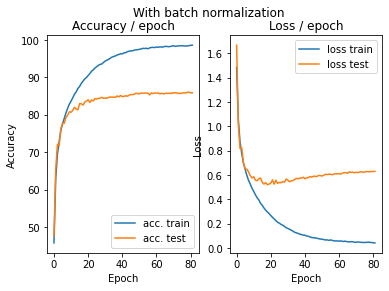

=== EPOCH 83 =====

[TRAIN Batch 000/391]	Time 0.159s (0.159s)	Loss 0.0652 (0.0652)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


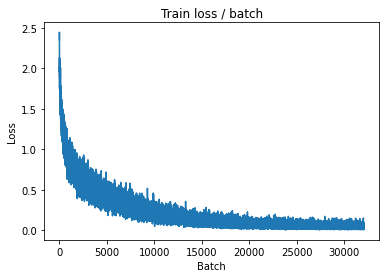

[TRAIN Batch 200/391]	Time 0.016s (0.037s)	Loss 0.0260 (0.0458)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


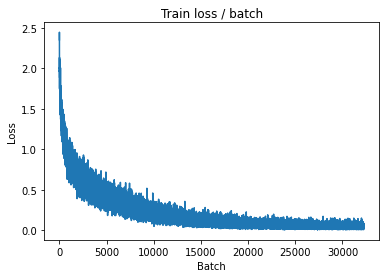


===============> Total time 14s	Avg loss 0.0444	Avg Prec@1 98.55 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.5083 (0.5083)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6298	Avg Prec@1 85.95 %	Avg Prec@5 99.27 %



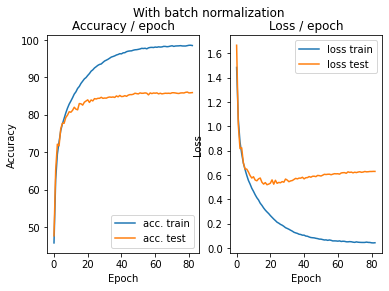

=== EPOCH 84 =====

[TRAIN Batch 000/391]	Time 0.201s (0.201s)	Loss 0.0332 (0.0332)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


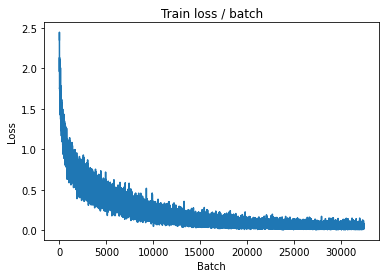

[TRAIN Batch 200/391]	Time 0.060s (0.039s)	Loss 0.0229 (0.0470)	Prec@1  99.2 ( 98.4)	Prec@5 100.0 (100.0)


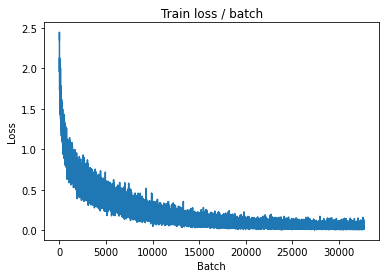


===============> Total time 14s	Avg loss 0.0473	Avg Prec@1 98.39 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 0.5056 (0.5056)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6314	Avg Prec@1 85.92 %	Avg Prec@5 99.28 %



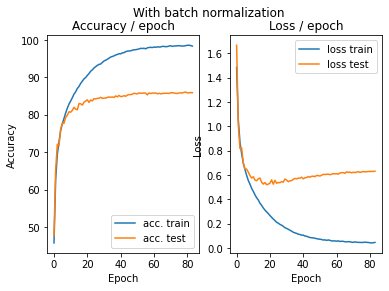

=== EPOCH 85 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.0418 (0.0418)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


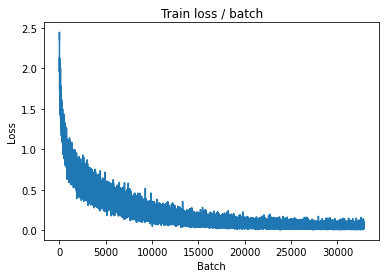

[TRAIN Batch 200/391]	Time 0.045s (0.038s)	Loss 0.0286 (0.0445)	Prec@1  98.4 ( 98.5)	Prec@5 100.0 (100.0)


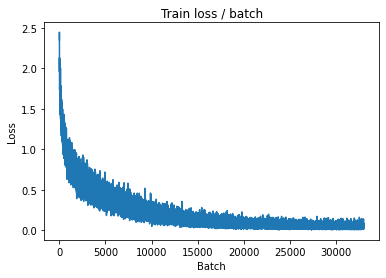


===============> Total time 14s	Avg loss 0.0441	Avg Prec@1 98.54 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 0.4948 (0.4948)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6315	Avg Prec@1 85.90 %	Avg Prec@5 99.31 %



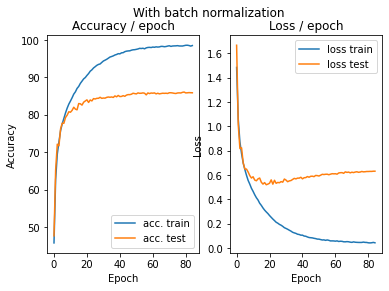

=== EPOCH 86 =====

[TRAIN Batch 000/391]	Time 0.166s (0.166s)	Loss 0.0570 (0.0570)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


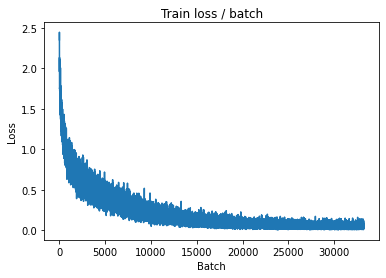

[TRAIN Batch 200/391]	Time 0.058s (0.039s)	Loss 0.0664 (0.0454)	Prec@1  98.4 ( 98.5)	Prec@5 100.0 (100.0)


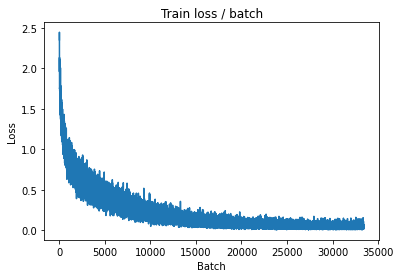


===============> Total time 14s	Avg loss 0.0449	Avg Prec@1 98.54 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.140s (0.140s)	Loss 0.4942 (0.4942)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6279	Avg Prec@1 85.85 %	Avg Prec@5 99.33 %



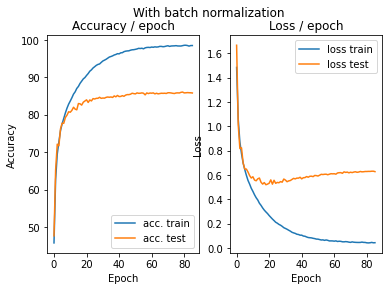

=== EPOCH 87 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 0.0183 (0.0183)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


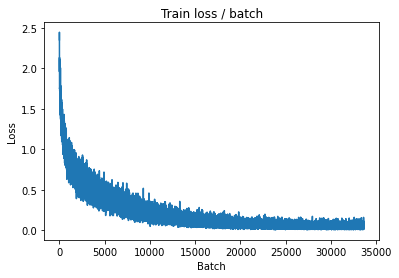

[TRAIN Batch 200/391]	Time 0.064s (0.038s)	Loss 0.0268 (0.0438)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)


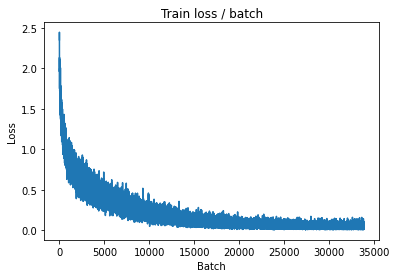


===============> Total time 14s	Avg loss 0.0444	Avg Prec@1 98.57 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.5113 (0.5113)	Prec@1  91.4 ( 91.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6336	Avg Prec@1 85.94 %	Avg Prec@5 99.32 %



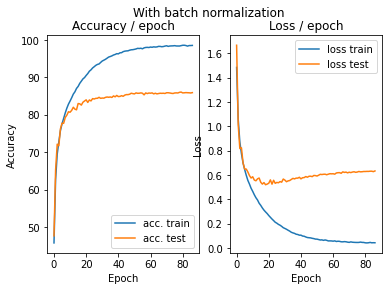

=== EPOCH 88 =====

[TRAIN Batch 000/391]	Time 0.185s (0.185s)	Loss 0.0268 (0.0268)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


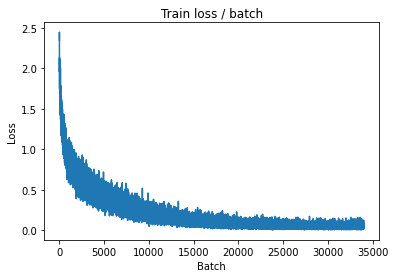

[TRAIN Batch 200/391]	Time 0.058s (0.040s)	Loss 0.0640 (0.0444)	Prec@1  96.9 ( 98.6)	Prec@5 100.0 (100.0)


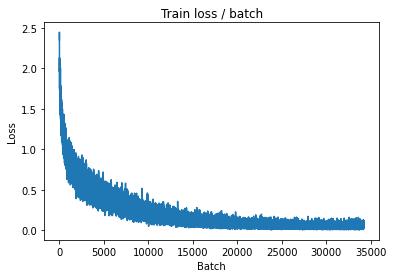


===============> Total time 15s	Avg loss 0.0444	Avg Prec@1 98.58 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.146s (0.146s)	Loss 0.5280 (0.5280)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6334	Avg Prec@1 86.07 %	Avg Prec@5 99.30 %



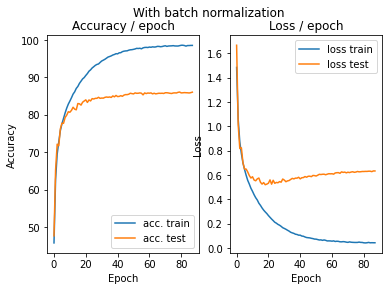

=== EPOCH 89 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.1200 (0.1200)	Prec@1  97.7 ( 97.7)	Prec@5  99.2 ( 99.2)


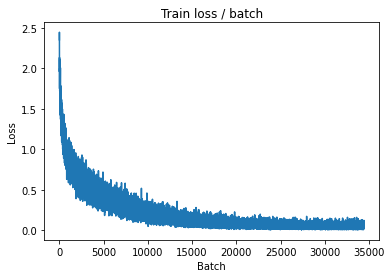

[TRAIN Batch 200/391]	Time 0.017s (0.041s)	Loss 0.0296 (0.0428)	Prec@1  98.4 ( 98.7)	Prec@5 100.0 (100.0)


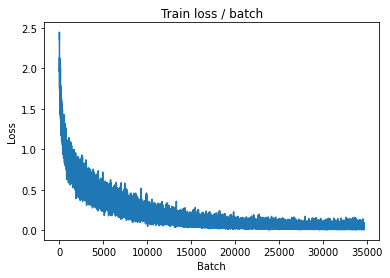


===============> Total time 15s	Avg loss 0.0433	Avg Prec@1 98.64 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.5197 (0.5197)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6324	Avg Prec@1 86.06 %	Avg Prec@5 99.36 %



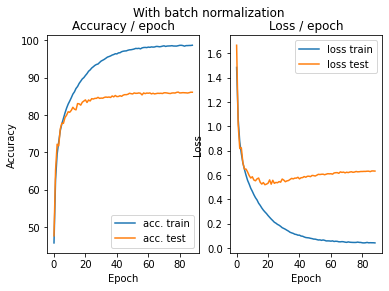

=== EPOCH 90 =====

[TRAIN Batch 000/391]	Time 0.190s (0.190s)	Loss 0.0396 (0.0396)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


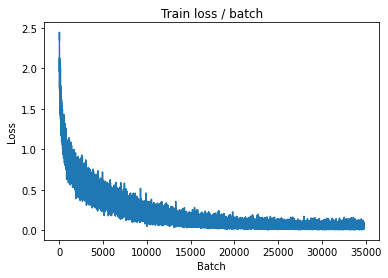

[TRAIN Batch 200/391]	Time 0.052s (0.040s)	Loss 0.0249 (0.0424)	Prec@1  99.2 ( 98.7)	Prec@5 100.0 (100.0)


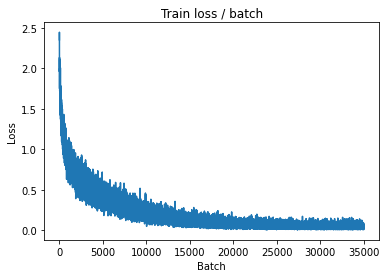


===============> Total time 15s	Avg loss 0.0415	Avg Prec@1 98.71 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 0.5257 (0.5257)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6355	Avg Prec@1 85.96 %	Avg Prec@5 99.29 %



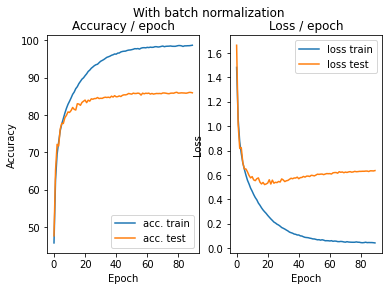

=== EPOCH 91 =====

[TRAIN Batch 000/391]	Time 0.179s (0.179s)	Loss 0.0104 (0.0104)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


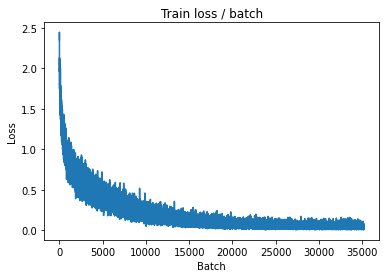

[TRAIN Batch 200/391]	Time 0.053s (0.038s)	Loss 0.0201 (0.0447)	Prec@1 100.0 ( 98.6)	Prec@5 100.0 (100.0)


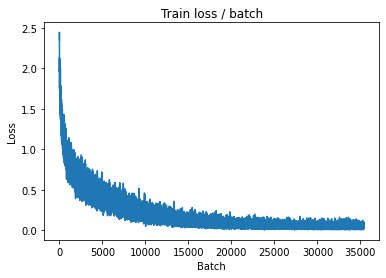


===============> Total time 14s	Avg loss 0.0454	Avg Prec@1 98.56 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 0.5125 (0.5125)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6307	Avg Prec@1 85.83 %	Avg Prec@5 99.28 %



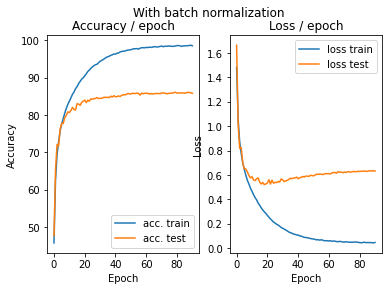

=== EPOCH 92 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.0733 (0.0733)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


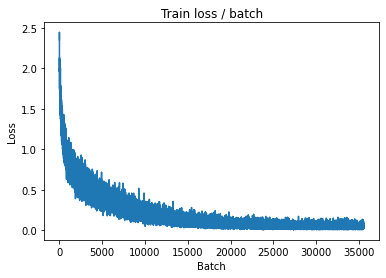

[TRAIN Batch 200/391]	Time 0.022s (0.039s)	Loss 0.0429 (0.0432)	Prec@1  98.4 ( 98.6)	Prec@5 100.0 (100.0)


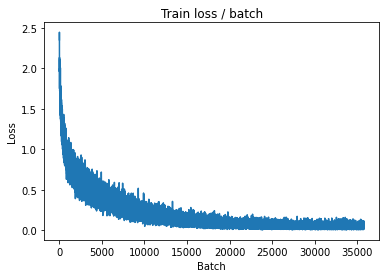


===============> Total time 15s	Avg loss 0.0428	Avg Prec@1 98.62 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.5196 (0.5196)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6312	Avg Prec@1 85.91 %	Avg Prec@5 99.30 %



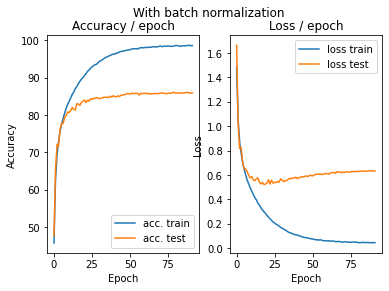

=== EPOCH 93 =====

[TRAIN Batch 000/391]	Time 0.186s (0.186s)	Loss 0.0339 (0.0339)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


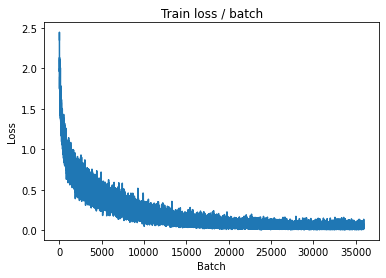

[TRAIN Batch 200/391]	Time 0.065s (0.040s)	Loss 0.0408 (0.0408)	Prec@1  98.4 ( 98.7)	Prec@5 100.0 (100.0)


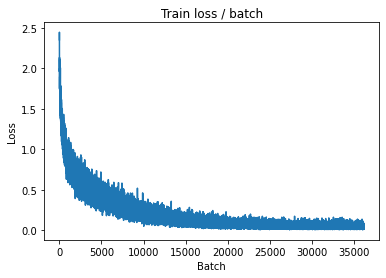


===============> Total time 15s	Avg loss 0.0434	Avg Prec@1 98.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.5241 (0.5241)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6345	Avg Prec@1 85.94 %	Avg Prec@5 99.35 %



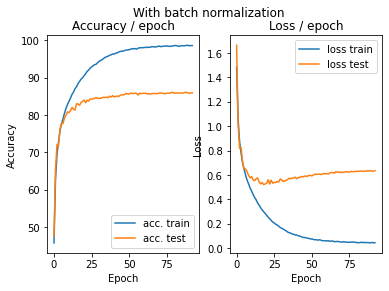

=== EPOCH 94 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.0579 (0.0579)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


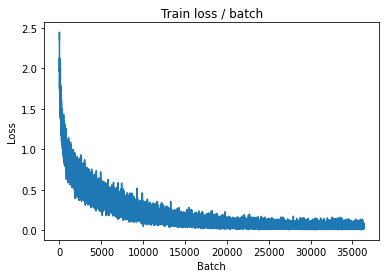

[TRAIN Batch 200/391]	Time 0.022s (0.040s)	Loss 0.0212 (0.0424)	Prec@1 100.0 ( 98.6)	Prec@5 100.0 (100.0)


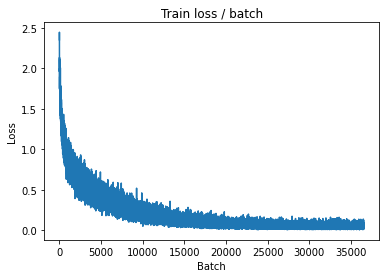


===============> Total time 15s	Avg loss 0.0423	Avg Prec@1 98.60 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 0.5257 (0.5257)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6339	Avg Prec@1 85.95 %	Avg Prec@5 99.32 %



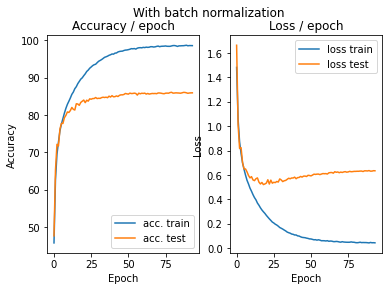

=== EPOCH 95 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.0253 (0.0253)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


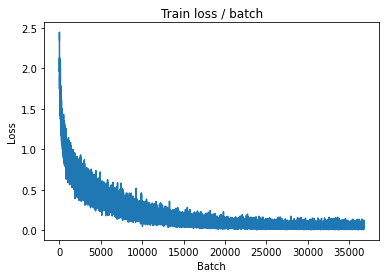

[TRAIN Batch 200/391]	Time 0.014s (0.040s)	Loss 0.0335 (0.0426)	Prec@1  98.4 ( 98.6)	Prec@5 100.0 (100.0)


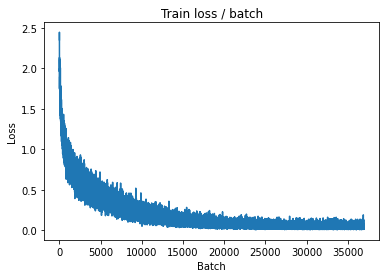


===============> Total time 15s	Avg loss 0.0430	Avg Prec@1 98.64 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.5210 (0.5210)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6330	Avg Prec@1 86.05 %	Avg Prec@5 99.33 %



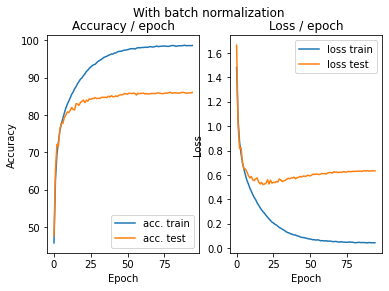

=== EPOCH 96 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.0504 (0.0504)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


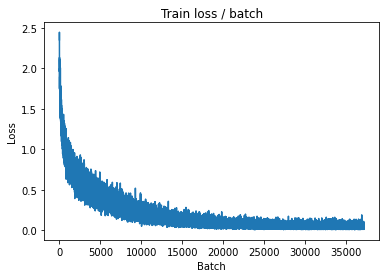

[TRAIN Batch 200/391]	Time 0.063s (0.040s)	Loss 0.0306 (0.0405)	Prec@1  99.2 ( 98.8)	Prec@5 100.0 (100.0)


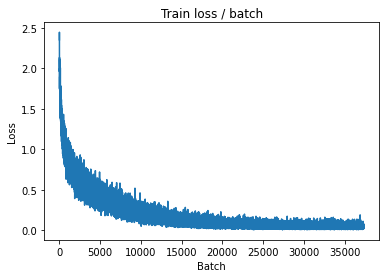


===============> Total time 15s	Avg loss 0.0411	Avg Prec@1 98.75 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.5147 (0.5147)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6346	Avg Prec@1 85.99 %	Avg Prec@5 99.29 %



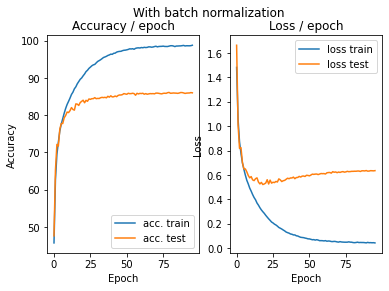

=== EPOCH 97 =====

[TRAIN Batch 000/391]	Time 0.189s (0.189s)	Loss 0.0389 (0.0389)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


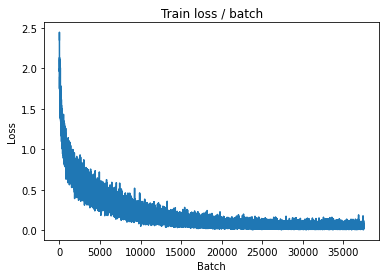

[TRAIN Batch 200/391]	Time 0.015s (0.041s)	Loss 0.0493 (0.0434)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)


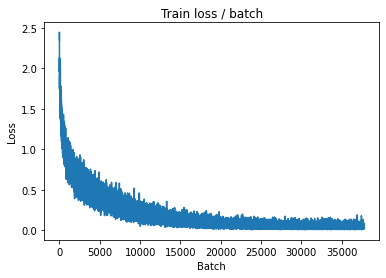


===============> Total time 15s	Avg loss 0.0425	Avg Prec@1 98.61 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.161s (0.161s)	Loss 0.5247 (0.5247)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6374	Avg Prec@1 85.91 %	Avg Prec@5 99.34 %



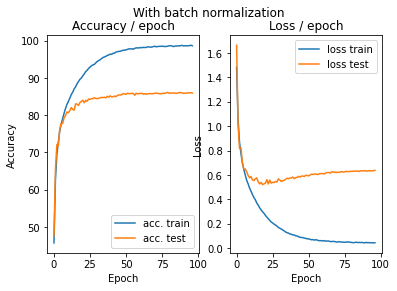

=== EPOCH 98 =====

[TRAIN Batch 000/391]	Time 0.205s (0.205s)	Loss 0.0566 (0.0566)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


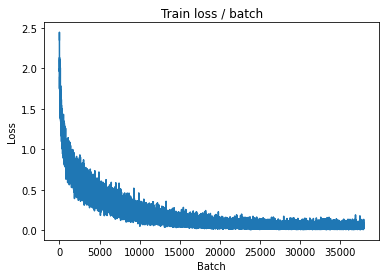

[TRAIN Batch 200/391]	Time 0.060s (0.039s)	Loss 0.0171 (0.0439)	Prec@1  99.2 ( 98.6)	Prec@5 100.0 (100.0)


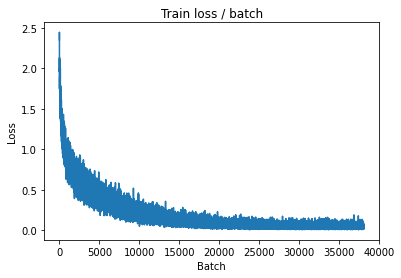


===============> Total time 15s	Avg loss 0.0435	Avg Prec@1 98.59 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.153s (0.153s)	Loss 0.5140 (0.5140)	Prec@1  89.1 ( 89.1)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6322	Avg Prec@1 86.02 %	Avg Prec@5 99.34 %



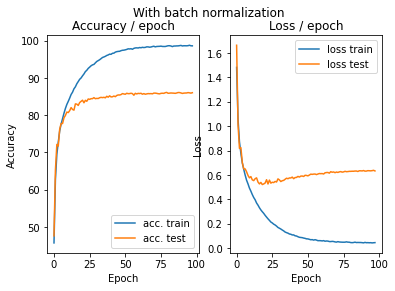

=== EPOCH 99 =====

[TRAIN Batch 000/391]	Time 0.176s (0.176s)	Loss 0.0207 (0.0207)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


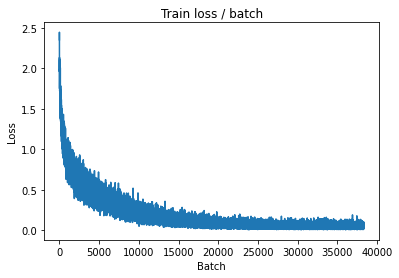

[TRAIN Batch 200/391]	Time 0.018s (0.040s)	Loss 0.0508 (0.0420)	Prec@1  98.4 ( 98.6)	Prec@5 100.0 (100.0)


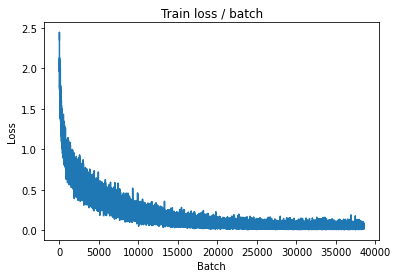


===============> Total time 15s	Avg loss 0.0422	Avg Prec@1 98.62 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.144s (0.144s)	Loss 0.5076 (0.5076)	Prec@1  89.8 ( 89.8)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6319	Avg Prec@1 85.96 %	Avg Prec@5 99.32 %



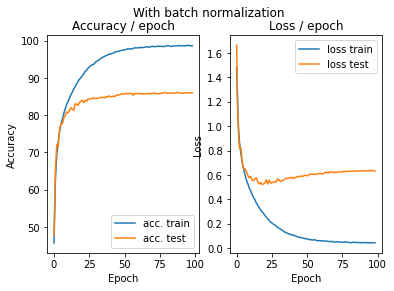

=== EPOCH 100 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.0280 (0.0280)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


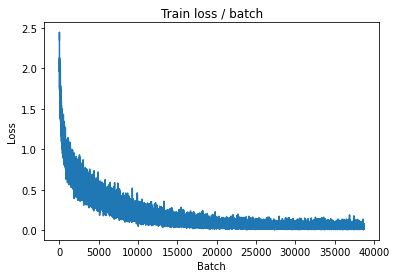

[TRAIN Batch 200/391]	Time 0.050s (0.042s)	Loss 0.0246 (0.0414)	Prec@1  98.4 ( 98.7)	Prec@5 100.0 (100.0)


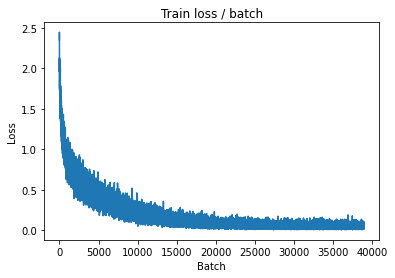


===============> Total time 15s	Avg loss 0.0404	Avg Prec@1 98.68 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.5192 (0.5192)	Prec@1  90.6 ( 90.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6380	Avg Prec@1 86.07 %	Avg Prec@5 99.33 %



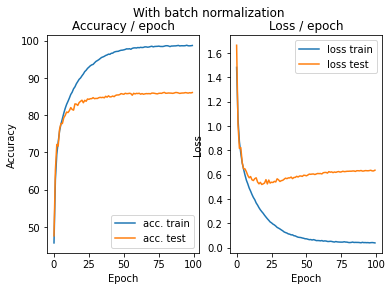

In [ ]:
main(128, 0.1, 100, cuda=True)

In [ ]:
d = get_dataset(128, True)

In [ ]:
d[0].dataset.data[:,:,:,2].mean()/255

In [ ]:
train_dataset = datasets.CIFAR10(
        PATH, train=True, download=True, transform=transforms.Compose(
            [transforms.RandomHorizontalFlip(),
             transforms.RandomCrop(size=28),
             transforms.ToTensor(),
             transforms.Normalize( mean=[0.491, 0.482, 0.447],
                                             std=[0.247, 0.243, 0.262])]))

In [ ]:
train_dataset

In [ ]:
res = torch.utils.data.DataLoader(train_dataset,
                        batch_size=128, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
res.dataset.data.shape